In [1]:
# imports
import json
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from pathlib import Path  # to save the mutational table 
import string

# to count the SARS-cov2 trinucleotide content
import sys
import Bio

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

In [2]:
# the different paths to the files
PATH_TO_HUMAN_COUNTS = "../data/codon_counts_GRCh37.json"
PATH_TO_SIGNATURES = "../data/external/COSMIC_v3.2_SBS_GRCh37.txt"
PATH_TO_SIGNATURES_NORMALIZED = "../data/COSMIC_v3.2_SBS_GRCh37_normalized.txt"
PATH_TO_REF_SEQ = "../data/sars-ref-seq.txt"

### Part 1: Opening COSMIC reference signatures, normalise them to trinucleotides frequency in humans 

In [3]:
# code from normalize_cosmic_signatures.py from https://github.com/kpotoh/signatures

def load_triplet_counts(path: str):
    """ read and collapse raw trinucleotide counts """
    with open(path) as fin:
        counts = json.load(fin)

    new_counts = defaultdict(int)
    for trinuc, num in counts.items():
        standart_trinuc = trinuc.upper()
        if len(set(standart_trinuc).difference("ATGC")) == 0:
            new_counts[standart_trinuc] += num
    return new_counts


def load_reference_sig(path: str):
    df = pd.read_csv(path, sep="\t")
    return df


def normalize(triplets, signatures):
    assert "Type" in signatures.columns
    ref_triplet = signatures.Type.apply(lambda s: "".join([s[0], s[2], s[-1]]))
    counts_raw = ref_triplet.map(triplets)
    counts = counts_raw / counts_raw.sum()

    signatures = signatures.set_index("Type")
    signatures_normed = signatures.div(counts.values, axis=0)
    signatures_normed = signatures_normed.div(
        signatures_normed.sum(axis=1).values, axis=0)
    return signatures_normed.reset_index()


# load the COSMIC signatures, normalise them to human trinucleotide content
triplets = load_triplet_counts(PATH_TO_HUMAN_COUNTS)
signatures = load_reference_sig(PATH_TO_SIGNATURES)
    
signatures_normed = normalize(triplets, signatures)
signatures_normed.to_csv(PATH_TO_SIGNATURES_NORMALIZED, index=None, sep="\t") # output path

In [4]:
signatures.head(100)

,Type,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,...,SBS85,SBS86,SBS87,SBS88,SBS89,SBS90,SBS91,SBS92,SBS93,SBS94
0,A[C>A]A,8.861572e-04,5.800168e-07,0.020808,0.042196,0.011998,0.000425,6.704351e-05,0.002329,0.004830,...,0.006080,0.002954,0.008973,0.000000,0.032169,0.002202,0.002945,0.011329,0.011573,0.015580
1,A[C>A]C,2.280405e-03,1.480043e-04,0.016507,0.033297,0.009438,0.000524,1.791162e-04,0.000461,0.001150,...,0.000880,0.003775,0.004573,0.000000,0.017694,0.000708,0.052997,0.009745,0.008096,0.024746
2,A[C>A]G,1.770314e-04,5.230151e-05,0.001751,0.015599,0.001850,0.000052,7.124623e-05,0.000186,0.000377,...,0.000306,0.000385,0.006209,0.000000,0.009671,0.000139,0.000204,0.004697,0.001761,0.001574
3,A[C>A]T,1.280227e-03,9.780282e-05,0.012205,0.029498,0.006609,0.000180,2.481610e-04,0.000710,0.001960,...,0.002717,0.003624,0.004957,0.001731,0.020744,0.001755,0.000131,0.007758,0.008421,0.011076
4,A[C>G]A,1.860330e-03,2.230064e-16,0.019708,0.006889,0.010098,0.000471,6.494214e-05,0.000009,0.001120,...,0.007235,0.052516,0.007866,0.000000,0.014817,0.000508,0.000243,0.003056,0.008857,0.007004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,T[T>C]T,4.330768e-03,3.580103e-05,0.013906,0.000636,0.018496,0.001741,8.125273e-04,0.002969,0.088107,...,0.094054,0.003439,0.006588,0.096365,0.006790,0.004000,0.001274,0.014287,0.014080,0.016766
92,T[T>G]A,2.230396e-16,1.670048e-05,0.007253,0.000377,0.005219,0.000105,1.280831e-04,0.000955,0.019302,...,0.007106,0.007136,0.008204,0.030583,0.006866,0.018583,0.005955,0.002208,0.053674,0.004072
93,T[T>G]C,5.510978e-05,7.040203e-05,0.006283,0.000174,0.006559,0.000287,1.160753e-04,0.001550,0.017401,...,0.006404,0.002369,0.002497,0.020773,0.002929,0.000185,0.000143,0.000301,0.013276,0.001235
94,T[T>G]G,5.831035e-04,9.540276e-05,0.008053,0.002320,0.006939,0.000324,2.231448e-16,0.001350,0.007641,...,0.003410,0.002011,0.001996,0.000000,0.005037,0.000293,0.000628,0.001743,0.012705,0.003048


In [5]:
signatures_normed.head(100)

,Type,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,...,SBS85,SBS86,SBS87,SBS88,SBS89,SBS90,SBS91,SBS92,SBS93,SBS94
0,A[C>A]A,8.050096e-04,5.269032e-07,0.018903,0.038332,0.010899,0.000386,6.090417e-05,0.002116,0.004388,...,0.005523,0.002684,0.008151,0.000000,0.029223,0.002000,0.002675,0.010292,0.010513,0.014153
1,A[C>A]C,2.874784e-03,1.865811e-04,0.020809,0.041976,0.011898,0.000661,2.258022e-04,0.000581,0.001450,...,0.001109,0.004758,0.005764,0.000000,0.022306,0.000893,0.066811,0.012285,0.010207,0.031196
2,A[C>A]G,9.587080e-04,2.832372e-04,0.009481,0.084474,0.010017,0.000282,3.858317e-04,0.001007,0.002042,...,0.001657,0.002088,0.033622,0.000000,0.052372,0.000750,0.001106,0.025434,0.009535,0.008525
3,A[C>A]T,1.753661e-03,1.339707e-04,0.016718,0.040406,0.009053,0.000247,3.399320e-04,0.000972,0.002685,...,0.003722,0.004964,0.006791,0.002371,0.028415,0.002404,0.000179,0.010627,0.011535,0.015172
4,A[C>G]A,4.751278e-03,5.695579e-16,0.050334,0.017596,0.025790,0.001204,1.658621e-04,0.000022,0.002861,...,0.018478,0.134126,0.020091,0.000000,0.037843,0.001298,0.000621,0.007805,0.022620,0.017888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,T[T>C]T,3.364824e-03,2.781589e-05,0.010804,0.000494,0.014371,0.001353,6.312993e-04,0.002307,0.068456,...,0.073076,0.002672,0.005118,0.074871,0.005275,0.003108,0.000990,0.011100,0.010940,0.013026
92,T[T>G]A,4.690500e-16,3.512095e-05,0.015253,0.000793,0.010975,0.000221,2.693575e-04,0.002008,0.040591,...,0.014945,0.015006,0.017254,0.064315,0.014438,0.039080,0.012523,0.004644,0.112875,0.008563
93,T[T>G]C,2.070064e-04,2.644480e-04,0.023599,0.000654,0.024636,0.001079,4.360085e-04,0.005821,0.065364,...,0.024057,0.008897,0.009380,0.078030,0.011002,0.000694,0.000539,0.001129,0.049868,0.004641
94,T[T>G]G,1.484125e-03,2.428207e-04,0.020497,0.005904,0.017660,0.000825,5.679519e-16,0.003435,0.019447,...,0.008679,0.005118,0.005080,0.000000,0.012821,0.000745,0.001599,0.004436,0.032338,0.007759


We only have 96 contexts (rows) here. Assuming strand symmetry, we add rows with complementary contexts and the same mutational probabilities, leading to all 192 possible contexts.

In [6]:
signatures_normed_copy = signatures_normed.copy()

In [7]:
signatures_normed_copy.head(10) # it is indeed the same

,Type,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,...,SBS85,SBS86,SBS87,SBS88,SBS89,SBS90,SBS91,SBS92,SBS93,SBS94
0,A[C>A]A,0.000805,5.269032e-07,0.018903,0.038332,0.010899,3.862934e-04,0.000061,0.002116,4.388074e-03,...,0.005523,0.002684,0.008151,0.000000,0.029223,0.002000,0.002675,0.010292,0.010513,0.014153
1,A[C>A]C,0.002875,1.865811e-04,0.020809,0.041976,0.011898,6.609409e-04,0.000226,0.000581,1.449865e-03,...,0.001109,0.004758,0.005764,0.000000,0.022306,0.000893,0.066811,0.012285,0.010207,0.031196
2,A[C>A]G,0.000959,2.832372e-04,0.009481,0.084474,0.010017,2.817587e-04,0.000386,0.001007,2.041803e-03,...,0.001657,0.002088,0.033622,0.000000,0.052372,0.000750,0.001106,0.025434,0.009535,0.008525
3,A[C>A]T,0.001754,1.339707e-04,0.016718,0.040406,0.009053,2.466999e-04,0.000340,0.000972,2.685042e-03,...,0.003722,0.004964,0.006791,0.002371,0.028415,0.002404,0.000179,0.010627,0.011535,0.015172
4,A[C>G]A,0.004751,5.695579e-16,0.050334,0.017596,0.025790,1.203592e-03,0.000166,0.000022,2.860718e-03,...,0.018478,0.134126,0.020091,0.000000,0.037843,0.001298,0.000621,0.007805,0.022620,0.017888
5,A[C>G]C,0.004739,5.165693e-04,0.045459,0.011029,0.022134,1.123053e-03,0.000084,0.000734,1.239058e-03,...,0.009909,0.304188,0.015279,0.015688,0.022850,0.001076,0.000484,0.006563,0.021043,0.015497
6,A[C>G]G,0.001079,1.426228e-04,0.002375,0.012009,0.016135,2.084125e-15,0.000477,0.004737,2.083158e-15,...,0.003961,0.046588,0.287694,0.000000,0.056771,0.000433,0.000443,0.008513,0.015309,0.005164
7,A[C>G]T,0.002714,2.170596e-04,0.041428,0.008448,0.024033,6.048440e-04,0.000228,0.000678,4.593730e-03,...,0.030987,0.219153,0.023134,0.009613,0.025943,0.002199,0.000192,0.009796,0.033086,0.016954
8,A[C>T]A,0.021108,5.158115e-05,0.011992,0.007344,0.027515,5.414188e-02,0.000103,0.001190,1.122859e-03,...,0.001161,0.007365,0.007956,0.008768,0.042123,0.000598,0.013307,0.020063,0.007548,0.006357
9,A[C>T]C,0.006700,1.462767e-03,0.013149,0.004430,0.018969,2.428606e-02,0.018773,0.040373,8.141064e-03,...,0.001567,0.002172,0.003769,0.000000,0.014332,0.000310,0.001288,0.014943,0.005375,0.015147


In [8]:
def replace_nucleotides(s):
    # function that replaces the type of mutation with the complementary nucleotides
    return s.replace('A', 't').replace('T', 'a').replace('C', 'g').replace('G', 'c').upper()

In [9]:
signatures_normed_copy["Type"] = signatures_normed_copy["Type"].apply(replace_nucleotides)
signatures_normed_copy.head(10)

,Type,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,...,SBS85,SBS86,SBS87,SBS88,SBS89,SBS90,SBS91,SBS92,SBS93,SBS94
0,T[G>T]T,0.000805,5.269032e-07,0.018903,0.038332,0.010899,3.862934e-04,0.000061,0.002116,4.388074e-03,...,0.005523,0.002684,0.008151,0.000000,0.029223,0.002000,0.002675,0.010292,0.010513,0.014153
1,T[G>T]G,0.002875,1.865811e-04,0.020809,0.041976,0.011898,6.609409e-04,0.000226,0.000581,1.449865e-03,...,0.001109,0.004758,0.005764,0.000000,0.022306,0.000893,0.066811,0.012285,0.010207,0.031196
2,T[G>T]C,0.000959,2.832372e-04,0.009481,0.084474,0.010017,2.817587e-04,0.000386,0.001007,2.041803e-03,...,0.001657,0.002088,0.033622,0.000000,0.052372,0.000750,0.001106,0.025434,0.009535,0.008525
3,T[G>T]A,0.001754,1.339707e-04,0.016718,0.040406,0.009053,2.466999e-04,0.000340,0.000972,2.685042e-03,...,0.003722,0.004964,0.006791,0.002371,0.028415,0.002404,0.000179,0.010627,0.011535,0.015172
4,T[G>C]T,0.004751,5.695579e-16,0.050334,0.017596,0.025790,1.203592e-03,0.000166,0.000022,2.860718e-03,...,0.018478,0.134126,0.020091,0.000000,0.037843,0.001298,0.000621,0.007805,0.022620,0.017888
5,T[G>C]G,0.004739,5.165693e-04,0.045459,0.011029,0.022134,1.123053e-03,0.000084,0.000734,1.239058e-03,...,0.009909,0.304188,0.015279,0.015688,0.022850,0.001076,0.000484,0.006563,0.021043,0.015497
6,T[G>C]C,0.001079,1.426228e-04,0.002375,0.012009,0.016135,2.084125e-15,0.000477,0.004737,2.083158e-15,...,0.003961,0.046588,0.287694,0.000000,0.056771,0.000433,0.000443,0.008513,0.015309,0.005164
7,T[G>C]A,0.002714,2.170596e-04,0.041428,0.008448,0.024033,6.048440e-04,0.000228,0.000678,4.593730e-03,...,0.030987,0.219153,0.023134,0.009613,0.025943,0.002199,0.000192,0.009796,0.033086,0.016954
8,T[G>A]T,0.021108,5.158115e-05,0.011992,0.007344,0.027515,5.414188e-02,0.000103,0.001190,1.122859e-03,...,0.001161,0.007365,0.007956,0.008768,0.042123,0.000598,0.013307,0.020063,0.007548,0.006357
9,T[G>A]G,0.006700,1.462767e-03,0.013149,0.004430,0.018969,2.428606e-02,0.018773,0.040373,8.141064e-03,...,0.001567,0.002172,0.003769,0.000000,0.014332,0.000310,0.001288,0.014943,0.005375,0.015147


Then, we need to reverse complement the "Type" column since the complementary strand is read from 5' to 3' as well.

In [10]:
def shift_nucleotides(s):
    # function that shifts the first and last nucleotide of the type column
    if len(s) <= 1:
        return s
 
    mid = s[1:len(s) - 1]
    return s[len(s) - 1] + mid + s[0]

In [11]:
signatures_normed_copy["Type"] = signatures_normed_copy["Type"].apply(shift_nucleotides)

In [12]:
signatures_normed_copy.head(10)

,Type,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,...,SBS85,SBS86,SBS87,SBS88,SBS89,SBS90,SBS91,SBS92,SBS93,SBS94
0,T[G>T]T,0.000805,5.269032e-07,0.018903,0.038332,0.010899,3.862934e-04,0.000061,0.002116,4.388074e-03,...,0.005523,0.002684,0.008151,0.000000,0.029223,0.002000,0.002675,0.010292,0.010513,0.014153
1,G[G>T]T,0.002875,1.865811e-04,0.020809,0.041976,0.011898,6.609409e-04,0.000226,0.000581,1.449865e-03,...,0.001109,0.004758,0.005764,0.000000,0.022306,0.000893,0.066811,0.012285,0.010207,0.031196
2,C[G>T]T,0.000959,2.832372e-04,0.009481,0.084474,0.010017,2.817587e-04,0.000386,0.001007,2.041803e-03,...,0.001657,0.002088,0.033622,0.000000,0.052372,0.000750,0.001106,0.025434,0.009535,0.008525
3,A[G>T]T,0.001754,1.339707e-04,0.016718,0.040406,0.009053,2.466999e-04,0.000340,0.000972,2.685042e-03,...,0.003722,0.004964,0.006791,0.002371,0.028415,0.002404,0.000179,0.010627,0.011535,0.015172
4,T[G>C]T,0.004751,5.695579e-16,0.050334,0.017596,0.025790,1.203592e-03,0.000166,0.000022,2.860718e-03,...,0.018478,0.134126,0.020091,0.000000,0.037843,0.001298,0.000621,0.007805,0.022620,0.017888
5,G[G>C]T,0.004739,5.165693e-04,0.045459,0.011029,0.022134,1.123053e-03,0.000084,0.000734,1.239058e-03,...,0.009909,0.304188,0.015279,0.015688,0.022850,0.001076,0.000484,0.006563,0.021043,0.015497
6,C[G>C]T,0.001079,1.426228e-04,0.002375,0.012009,0.016135,2.084125e-15,0.000477,0.004737,2.083158e-15,...,0.003961,0.046588,0.287694,0.000000,0.056771,0.000433,0.000443,0.008513,0.015309,0.005164
7,A[G>C]T,0.002714,2.170596e-04,0.041428,0.008448,0.024033,6.048440e-04,0.000228,0.000678,4.593730e-03,...,0.030987,0.219153,0.023134,0.009613,0.025943,0.002199,0.000192,0.009796,0.033086,0.016954
8,T[G>A]T,0.021108,5.158115e-05,0.011992,0.007344,0.027515,5.414188e-02,0.000103,0.001190,1.122859e-03,...,0.001161,0.007365,0.007956,0.008768,0.042123,0.000598,0.013307,0.020063,0.007548,0.006357
9,G[G>A]T,0.006700,1.462767e-03,0.013149,0.004430,0.018969,2.428606e-02,0.018773,0.040373,8.141064e-03,...,0.001567,0.002172,0.003769,0.000000,0.014332,0.000310,0.001288,0.014943,0.005375,0.015147


It does indeed what we wanted.

Next, we merge the two dataframes to get the 192 probabilities.

In [13]:
signatures_normed = pd.concat([signatures_normed, signatures_normed_copy], ignore_index=True)

In [14]:
signatures_normed.loc[:, "SBS20"]

0      5.625741e-04
1      1.753101e-03
2      1.181113e-04
3      1.699335e-03
4      2.240881e-02
           ...     
187    1.500215e-02
188    4.670775e-16
189    8.342703e-16
190    7.104405e-03
191    9.480722e-04
Name: SBS20, Length: 192, dtype: float64

This is the sbs20 signature as example, with 192 contexts, normalised to human trinucleotide frequency.

### We create a random mutational signature according to which it could mutate. 
SigProExtractor shouldn't be able to reconstruct anything meaningful.

In [15]:
np.random.seed(70) #before =42
signatures_normed['SBS_random'] = np.random.rand(192,1)

In [16]:
signatures_normed.head()

,Type,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,...,SBS86,SBS87,SBS88,SBS89,SBS90,SBS91,SBS92,SBS93,SBS94,SBS_random
0,A[C>A]A,0.000805,5.269032e-07,0.018903,0.038332,0.010899,0.000386,0.000061,0.002116,0.004388,...,0.002684,0.008151,0.000000,0.029223,0.002000,0.002675,0.010292,0.010513,0.014153,0.927481
1,A[C>A]C,0.002875,1.865811e-04,0.020809,0.041976,0.011898,0.000661,0.000226,0.000581,0.001450,...,0.004758,0.005764,0.000000,0.022306,0.000893,0.066811,0.012285,0.010207,0.031196,0.872426
2,A[C>A]G,0.000959,2.832372e-04,0.009481,0.084474,0.010017,0.000282,0.000386,0.001007,0.002042,...,0.002088,0.033622,0.000000,0.052372,0.000750,0.001106,0.025434,0.009535,0.008525,0.584631
3,A[C>A]T,0.001754,1.339707e-04,0.016718,0.040406,0.009053,0.000247,0.000340,0.000972,0.002685,...,0.004964,0.006791,0.002371,0.028415,0.002404,0.000179,0.010627,0.011535,0.015172,0.905170
4,A[C>G]A,0.004751,5.695579e-16,0.050334,0.017596,0.025790,0.001204,0.000166,0.000022,0.002861,...,0.134126,0.020091,0.000000,0.037843,0.001298,0.000621,0.007805,0.022620,0.017888,0.316833


Now we create a new column with the trinucleotide context before the mutation.

In [17]:
# get the nucleotides of the Type column
signatures_normed["Context"] = signatures_normed.Type.str.slice(start=0, stop=7, step=2) 

In [18]:
sig_normed = signatures_normed.copy()

# drop the third value to get the trinucleotide context before each mutation 
for i, strObj in enumerate(signatures_normed["Context"]):
    index = 2
    if len(strObj) > index:
        strObj = strObj[0 : index : ] + strObj[index + 1 : :]
    sig_normed["Context"][i] = strObj


<ipython-input-18-3888a268b229>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_normed["Context"][i] = strObj


In [19]:
sig_normed.head()

,Type,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,...,SBS87,SBS88,SBS89,SBS90,SBS91,SBS92,SBS93,SBS94,SBS_random,Context
0,A[C>A]A,0.000805,5.269032e-07,0.018903,0.038332,0.010899,0.000386,0.000061,0.002116,0.004388,...,0.008151,0.000000,0.029223,0.002000,0.002675,0.010292,0.010513,0.014153,0.927481,ACA
1,A[C>A]C,0.002875,1.865811e-04,0.020809,0.041976,0.011898,0.000661,0.000226,0.000581,0.001450,...,0.005764,0.000000,0.022306,0.000893,0.066811,0.012285,0.010207,0.031196,0.872426,ACC
2,A[C>A]G,0.000959,2.832372e-04,0.009481,0.084474,0.010017,0.000282,0.000386,0.001007,0.002042,...,0.033622,0.000000,0.052372,0.000750,0.001106,0.025434,0.009535,0.008525,0.584631,ACG
3,A[C>A]T,0.001754,1.339707e-04,0.016718,0.040406,0.009053,0.000247,0.000340,0.000972,0.002685,...,0.006791,0.002371,0.028415,0.002404,0.000179,0.010627,0.011535,0.015172,0.905170,ACT
4,A[C>G]A,0.004751,5.695579e-16,0.050334,0.017596,0.025790,0.001204,0.000166,0.000022,0.002861,...,0.020091,0.000000,0.037843,0.001298,0.000621,0.007805,0.022620,0.017888,0.316833,ACA


## Here we can choose which signature(s) we would like to test the pipeline on 
#### /!\ it must correspond to the choice in the script in_silico_mutagenesis.py

In [20]:
SBS = 'SBS20'
#SBS = 'SBS25'
#SBS = 'SBS34'
#SBS = 'SBS_random' # for the negative control

If we want to choose another signature to mutate the sequence at the same time:

In [21]:
#SBS2 = 'SBS34'
#SBS2 = 'SBS25'

#unique_sig = False # comment if you want to use only 1 signature
unique_sig = True # comment if you want to use more than 1 signature

In [22]:
print("You have chosen to try the pipeline on the", SBS, "mutational signature from COSMIC.")

if unique_sig == False:
    print('As well as the', SBS2, "signature.")

You have chosen to try the pipeline on the SBS20 mutational signature from COSMIC.


In [23]:
sbs = sig_normed.loc[:,["Type", SBS, "Context"]]
sbs = sbs.rename(columns={SBS: "SBS"})

if unique_sig == False:
    sbs2 = sig_normed.loc[:,["Type", SBS2, "Context"]]
    sbs2 = sbs2.rename(columns={SBS2: "SBS2"})

In [24]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(sbs)
    
# There are indeed 192 probabilites, not 96

        Type           SBS Context
0    A[C>A]A  5.625741e-04     ACA
1    A[C>A]C  1.753101e-03     ACC
2    A[C>A]G  1.181113e-04     ACG
3    A[C>A]T  1.699335e-03     ACT
4    A[C>G]A  2.240881e-02     ACA
5    A[C>G]C  5.867325e-03     ACC
6    A[C>G]G  4.402552e-03     ACG
7    A[C>G]T  1.052429e-02     ACT
8    A[C>T]A  4.163734e-02     ACA
9    A[C>T]C  1.378560e-02     ACC
10   A[C>T]G  1.147623e-02     ACG
11   A[C>T]T  1.372329e-02     ACT
12   A[T>A]A  4.598674e-04     ATA
13   A[T>A]C  1.705198e-02     ATC
14   A[T>A]G  8.349961e-04     ATG
15   A[T>A]T  2.143186e-02     ATT
16   A[T>C]A  7.779866e-03     ATA
17   A[T>C]C  8.748276e-03     ATC
18   A[T>C]G  1.938444e-02     ATG
19   A[T>C]T  9.475307e-05     ATT
20   A[T>G]A  3.166148e-05     ATA
21   A[T>G]C  1.547946e-04     ATC
22   A[T>G]G  6.544002e-05     ATG
23   A[T>G]T  1.225350e-04     ATT
24   C[C>A]A  1.747307e-02     CCA
25   C[C>A]C  9.419889e-02     CCC
26   C[C>A]G  7.152749e-03     CCG
27   C[C>A]T  1.3278

In [25]:
sbs.head(10)

,Type,SBS,Context
0,A[C>A]A,0.000563,ACA
1,A[C>A]C,0.001753,ACC
2,A[C>A]G,0.000118,ACG
3,A[C>A]T,0.001699,ACT
4,A[C>G]A,0.022409,ACA
5,A[C>G]C,0.005867,ACC
6,A[C>G]G,0.004403,ACG
7,A[C>G]T,0.010524,ACT
8,A[C>T]A,0.041637,ACA
9,A[C>T]C,0.013786,ACC


In [26]:
if unique_sig == False:
    sbs2.head(10)

This is the normalized chosen SBS signature which includes the context.

### Part 2: Opening the SARS-Cov2 reference sequence

In [27]:
with open(PATH_TO_REF_SEQ) as f:
    ref_seq_raw = f.readlines()

In [28]:
ref_seq = " ".join(ref_seq_raw) # concatenate the string
ref_seq.replace(" ", "")
print("The SARS-Cov2 reference sequence is:")
print(ref_seq)

The SARS-Cov2 reference sequence is:
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAA
 CGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAAC
 TAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTG
 TTGCAGCCGATCATCAGCACATCTAGGTTTCGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTC
 CCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTAC
 GTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGG
 CTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGAT
 GCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTC
 GTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCT
 TCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTA
 GGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTG
 TTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGG
 CCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTG
 TCCGAACAACTGGACTTTATTGACACT

In [29]:
lst = list(ref_seq) # convert to vector of char to be able to sample fast

buffer = []
for c in lst:
    if c != "\n" and c != ' ':
        buffer.append(c)
        
print(buffer)

['A', 'T', 'T', 'A', 'A', 'A', 'G', 'G', 'T', 'T', 'T', 'A', 'T', 'A', 'C', 'C', 'T', 'T', 'C', 'C', 'C', 'A', 'G', 'G', 'T', 'A', 'A', 'C', 'A', 'A', 'A', 'C', 'C', 'A', 'A', 'C', 'C', 'A', 'A', 'C', 'T', 'T', 'T', 'C', 'G', 'A', 'T', 'C', 'T', 'C', 'T', 'T', 'G', 'T', 'A', 'G', 'A', 'T', 'C', 'T', 'G', 'T', 'T', 'C', 'T', 'C', 'T', 'A', 'A', 'A', 'C', 'G', 'A', 'A', 'C', 'T', 'T', 'T', 'A', 'A', 'A', 'A', 'T', 'C', 'T', 'G', 'T', 'G', 'T', 'G', 'G', 'C', 'T', 'G', 'T', 'C', 'A', 'C', 'T', 'C', 'G', 'G', 'C', 'T', 'G', 'C', 'A', 'T', 'G', 'C', 'T', 'T', 'A', 'G', 'T', 'G', 'C', 'A', 'C', 'T', 'C', 'A', 'C', 'G', 'C', 'A', 'G', 'T', 'A', 'T', 'A', 'A', 'T', 'T', 'A', 'A', 'T', 'A', 'A', 'C', 'T', 'A', 'A', 'T', 'T', 'A', 'C', 'T', 'G', 'T', 'C', 'G', 'T', 'T', 'G', 'A', 'C', 'A', 'G', 'G', 'A', 'C', 'A', 'C', 'G', 'A', 'G', 'T', 'A', 'A', 'C', 'T', 'C', 'G', 'T', 'C', 'T', 'A', 'T', 'C', 'T', 'T', 'C', 'T', 'G', 'C', 'A', 'G', 'G', 'C', 'T', 'G', 'C', 'T', 'T', 'A', 'C', 'G', 'G', 'T',

In [30]:
print("There are:", len(buffer), "nucleotides in the SARS-Cov2 genome")

There are: 29903 nucleotides in the SARS-Cov2 genome


### Part 3: Doing the actual mutagenesis experiment on the SARS-cov2 reference sequence

This "Part 3" pipeline illustrates what happens in the python script for the in silico mutagenesis experiment. This script, in_silico_mutagenesis.py, runs the loop until n mutations are accumulated and puts the resulting mutated sars-cov2 sequence in the results_n.txt file, in the results directory. It also saves the mutational table with the mutation type and the number of mutations in the mut_table_n.tsv file in the same directory.

To run it, write:

$python3 in_silico_mutagenesis.py 

in the terminal where the script is located.
You can change the number of mutations desired, the value of the variable n, directly in the script after "#3.".

In [31]:
# Sample a random nucleotide from the sequence and get the context

seq = buffer
nt = np.random.randint(1, len(buffer)-1, size=1)
print("Sampled nucleotide number:", nt[0]) 

print("This nucleotide is:", seq[nt[0]])
list_context = [seq[nt[0]-1],seq[nt[0]],seq[nt[0]+1]]
context = ''.join(list_context)
print('The context is:', context)

Sampled nucleotide number: 25214
This nucleotide is: T
The context is: CTA


In [32]:
# Check the probabilities in the sbs signature
subdf = sbs.loc[sbs['Context'] == context]

if unique_sig == False:
    subdf2 = sbs2.loc[sbs2['Context'] == context]

In [33]:
subdf.head(10)

,Type,SBS,Context
36,C[T>A]A,0.000159,CTA
40,C[T>C]A,0.020977,CTA
44,C[T>G]A,0.005134,CTA


In [34]:
if unique_sig == False:
    subdf2.head(10)

In [35]:
# Draw random number between 0 and 1
# rand_nb = np.random.random_sample()

#FOR THE TEST ONLY:
rand_nb = 0.0001
print("Random number:", rand_nb)

Random number: 0.0001


In [36]:
# Sum all three mutational probabilities, if higher than rand_nb: mutate, otherwise: not
sum_probas = subdf['SBS'].values.sum()
print("The sum of the mutational probabilities:", sum_probas)
mutate = False

if sum_probas > rand_nb:
    mutate = True
    print('Mutate !')
else:
    print('Dont mutate !')

The sum of the mutational probabilities: 0.02626987356615849
Mutate !


In [37]:
# Get the normalised probas, that sum up to 1
subdf_normed = subdf.copy()
subdf_normed['SBS']= subdf['SBS'].values/sum_probas

if unique_sig == False:
    subdf_normed2 = subdf2.copy()
    subdf_normed2['SBS2']= subdf2['SBS2'].values/sum_probas

In [38]:
subdf_normed.head(10)

,Type,SBS,Context
36,C[T>A]A,0.006063,CTA
40,C[T>C]A,0.798520,CTA
44,C[T>G]A,0.195417,CTA


In [39]:
if unique_sig == False:
    subdf_normed2.head(10)

In [40]:
if mutate == True: # so if the probability is bigger than the random number drawn
    # Choose randomly which type of mutation it will be
    
    if unique_sig == True: 
        chosen_mut = subdf_normed.sample(n=1, weights='SBS')  
    
    # If we have two signatures to mutate with, let's say, 50% each probability
        
    elif unique_sig == False:
        
        if rand_nb > 0.5: 
            chosen_mut = subdf_normed.sample(n=1, weights='SBS')
        else: 
            chosen_mut = subdf_normed2.sample(n=1, weights='SBS2')
    
    print(chosen_mut)

       Type      SBS Context
40  C[T>C]A  0.79852     CTA


In [41]:
# Extract the nucleotide to mutate into
if mutate == True: 
    mut_nt = chosen_mut.Type.str.slice(start=4, stop=5, step=1)
    print("The nucleotide to mutate into is:", mut_nt.values[0])

The nucleotide to mutate into is: C


### Mutate the reference sequence

In [42]:
buffer[nt[0]] = mut_nt.values[0]
print(buffer[nt[0]])

C


### Part 4: Getting the resulting sequence and mutagenesis profile

We first open the resulting mutated sars-cov2 sequence from running the in_silico_mutagenesis.py script to take a look.

## !! We choose here which file, with which number n_mut of mutations done, to open

In [43]:
n_mut = 100 # choose here the file with which number of mutations to open

In [44]:
# Open the results file with n mutations for instance

with open('../results/results/{}_mut/results_{}.txt'.format(n_mut, n_mut)) as f:
    new_seq = f.readlines()

In [45]:
# remove the white spaces
new_seq = " ".join(new_seq) # concatenate the string
new_seq.replace(" ", "")

new_seq = new_seq.translate({ord(c): None for c in string.whitespace})

print("The mutated SARS-Cov2 reference sequence is:")
print(new_seq)

The mutated SARS-Cov2 reference sequence is:
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTCGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCATGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACATCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTTGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGC

In [46]:
lst = list(new_seq) # converts to vector of char in case it is needed later

buffer_2 = []
for c in lst:
    if c != "\n" and c != ' ':
        buffer_2.append(c)

We now open the tsv file containing the mutational spectrum from the in silico mutagenesis experiment, for example here with 500 mutations.

In [47]:
mut_table = pd.read_table('../results/results/{}_mut/mut_table_{}.tsv'.format(n_mut, n_mut))
mut_table = mut_table.drop(columns=['Unnamed: 0'])
mut_table.head(10)

,Type,Number
0,A[C>A]A,0
1,A[C>A]C,0
2,A[C>A]G,0
3,A[C>A]T,0
4,A[C>G]A,2
5,A[C>G]C,0
6,A[C>G]G,0
7,A[C>G]T,1
8,A[C>T]A,2
9,A[C>T]C,0


In [48]:
# add the context column
mut_table["Context"] = mut_table.Type.str.slice(start=0, stop=7, step=2) 
# drop the third value to get the trinucleotide context before each mutation 
for i, strObj in enumerate(mut_table["Context"]):
    index = 2
    if len(strObj) > index:
        strObj = strObj[0 : index : ] + strObj[index + 1 : :]
    mut_table["Context"][i] = strObj

<ipython-input-48-e3811cf8d92d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mut_table["Context"][i] = strObj


In [49]:
mut_table.head()

,Type,Number,Context
0,A[C>A]A,0,ACA
1,A[C>A]C,0,ACC
2,A[C>A]G,0,ACG
3,A[C>A]T,0,ACT
4,A[C>G]A,2,ACA


We can print the bar plot of the mutational table to represent this visually.

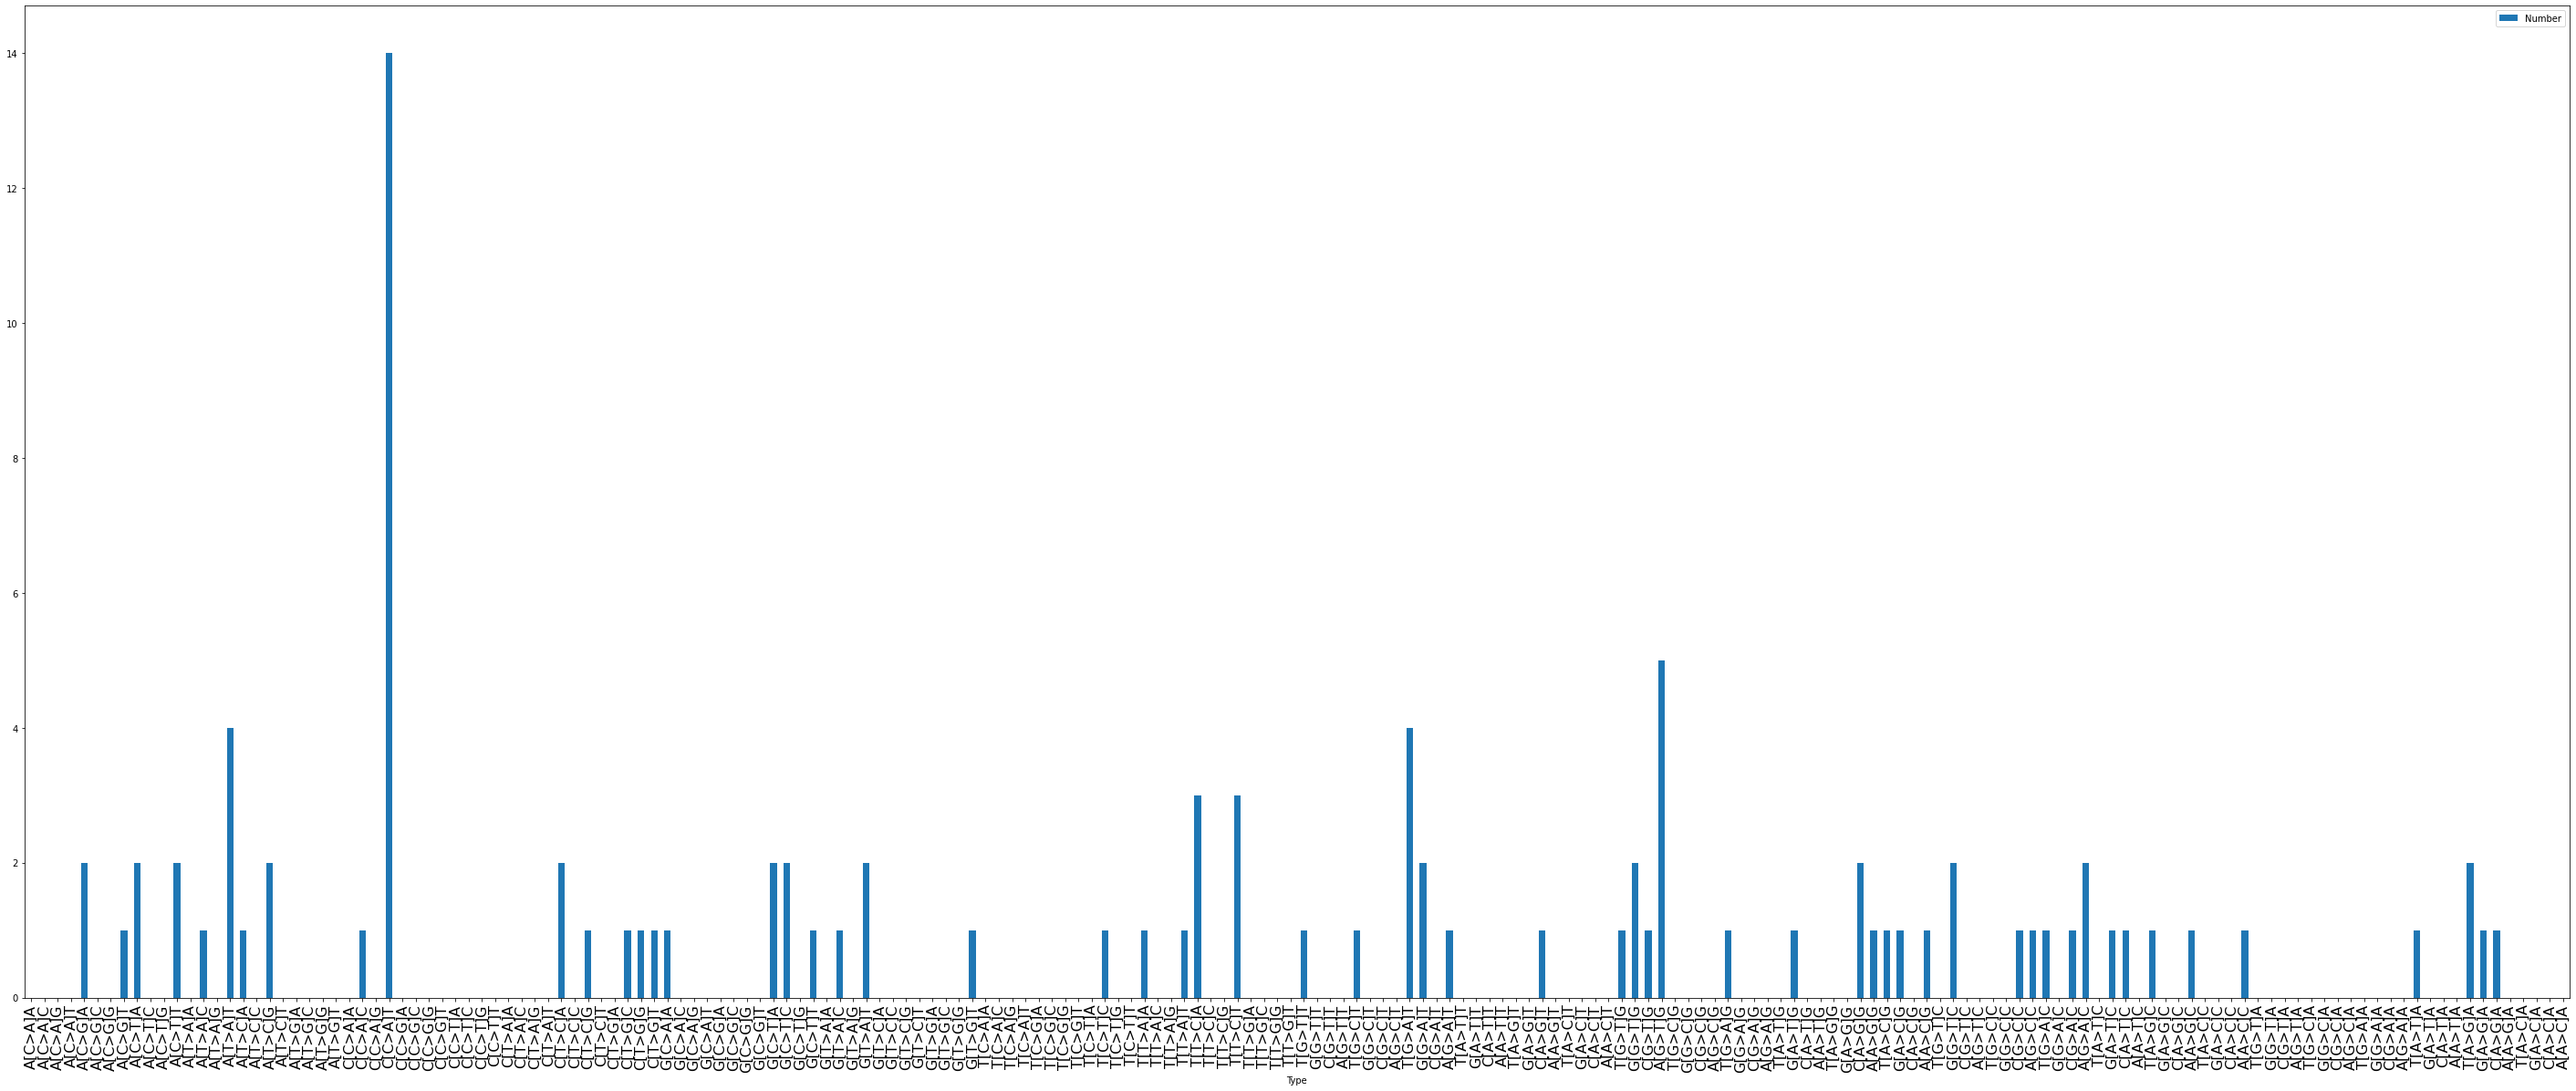

In [50]:
ax = mut_table.plot.bar(x='Type', y='Number', rot=90, figsize=(50,20))
ax.tick_params(axis='x', which='both', labelsize=16)

Now that we have it, we should perform double-step normalisation to go back to the human mutational table and be able to compare it: 

1) divide by SARScov2 reference sequence trinucleotide content

2) multiply by human trinucleotide frequency and reduce to 96 mutation types before feeding to SigProExtractor

### Part 5: Doing two steps normalisation to get back to human-comparable mutational spectrum

#### 1) divide by SARScov2 reference sequence trinucleotide count

#### Now we count the codons in the original SARS-cov2 reference sequence

In [51]:
# code from count_codons.py from https://github.com/kpotoh/signatures

PATH_TO_GENOME = "../data/ref_seq_sars.fna" # fasta file of SARS-cov2 reference sequence
PATH_TO_JSON_OUT = "../data/codon_counts_sars.json"

NUCL_SET = set("ACGTacgt")


def is_appropriate_codon(codon: str) -> bool:
    return len(set(codon).difference(NUCL_SET)) == 0


codon_counts = defaultdict(int)
fasta = SeqIO.parse(PATH_TO_GENOME, "fasta")
rec: SeqRecord = None
for rec in fasta:
    print("Processing...", rec.description, file=sys.stderr)
    seq = str(rec.seq)
    # iterate over codons with window=1
    for i in range(len(seq) - 2):
        codon = seq[i: i + 3]
        if is_appropriate_codon(codon):
            codon_counts[codon] += 1

print(codon_counts, file=sys.stderr)
with open(PATH_TO_JSON_OUT, "w") as fout:
    json.dump(codon_counts, fout)

Processing... NC_045512.2 Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome
defaultdict(<class 'int'>, {'ATT': 773, 'TTA': 876, 'TAA': 719, 'AAA': 923, 'AAG': 580, 'AGG': 329, 'GGT': 454, 'GTT': 700, 'TTT': 1004, 'TAT': 622, 'ATA': 471, 'TAC': 609, 'ACC': 376, 'CCT': 344, 'CTT': 738, 'TTC': 518, 'TCC': 209, 'CCC': 116, 'CCA': 354, 'CAG': 438, 'GTA': 469, 'AAC': 615, 'ACA': 809, 'CAA': 703, 'ACT': 674, 'TCG': 113, 'CGA': 95, 'GAT': 440, 'ATC': 339, 'TCT': 542, 'CTC': 287, 'TTG': 817, 'TGT': 858, 'TAG': 427, 'AGA': 605, 'CTG': 495, 'CTA': 561, 'ACG': 164, 'GAA': 535, 'AAT': 761, 'GTG': 552, 'TGG': 554, 'GGC': 223, 'GCT': 521, 'GTC': 269, 'TCA': 549, 'CAC': 459, 'CGG': 76, 'TGC': 547, 'GCA': 372, 'CAT': 484, 'ATG': 725, 'AGT': 507, 'CGC': 97, 'CGT': 171, 'TGA': 630, 'GAC': 340, 'GGA': 282, 'GAG': 297, 'CCG': 74, 'AGC': 301, 'GCC': 187, 'GGG': 134, 'GCG': 88})


In [52]:
triplets = load_triplet_counts(PATH_TO_JSON_OUT)

print(triplets)
print("There are: ", len(triplets), "entries")
if len(triplets) == 4*4*4:
    print("Sanity check ok") # ok, sanity check 

defaultdict(<class 'int'>, {'ATT': 773, 'TTA': 876, 'TAA': 719, 'AAA': 923, 'AAG': 580, 'AGG': 329, 'GGT': 454, 'GTT': 700, 'TTT': 1004, 'TAT': 622, 'ATA': 471, 'TAC': 609, 'ACC': 376, 'CCT': 344, 'CTT': 738, 'TTC': 518, 'TCC': 209, 'CCC': 116, 'CCA': 354, 'CAG': 438, 'GTA': 469, 'AAC': 615, 'ACA': 809, 'CAA': 703, 'ACT': 674, 'TCG': 113, 'CGA': 95, 'GAT': 440, 'ATC': 339, 'TCT': 542, 'CTC': 287, 'TTG': 817, 'TGT': 858, 'TAG': 427, 'AGA': 605, 'CTG': 495, 'CTA': 561, 'ACG': 164, 'GAA': 535, 'AAT': 761, 'GTG': 552, 'TGG': 554, 'GGC': 223, 'GCT': 521, 'GTC': 269, 'TCA': 549, 'CAC': 459, 'CGG': 76, 'TGC': 547, 'GCA': 372, 'CAT': 484, 'ATG': 725, 'AGT': 507, 'CGC': 97, 'CGT': 171, 'TGA': 630, 'GAC': 340, 'GGA': 282, 'GAG': 297, 'CCG': 74, 'AGC': 301, 'GCC': 187, 'GGG': 134, 'GCG': 88})
There are:  64 entries
Sanity check ok


In [53]:
# Sort the triplets 
triplets = dict(sorted(triplets.items()))
print(triplets)

{'AAA': 923, 'AAC': 615, 'AAG': 580, 'AAT': 761, 'ACA': 809, 'ACC': 376, 'ACG': 164, 'ACT': 674, 'AGA': 605, 'AGC': 301, 'AGG': 329, 'AGT': 507, 'ATA': 471, 'ATC': 339, 'ATG': 725, 'ATT': 773, 'CAA': 703, 'CAC': 459, 'CAG': 438, 'CAT': 484, 'CCA': 354, 'CCC': 116, 'CCG': 74, 'CCT': 344, 'CGA': 95, 'CGC': 97, 'CGG': 76, 'CGT': 171, 'CTA': 561, 'CTC': 287, 'CTG': 495, 'CTT': 738, 'GAA': 535, 'GAC': 340, 'GAG': 297, 'GAT': 440, 'GCA': 372, 'GCC': 187, 'GCG': 88, 'GCT': 521, 'GGA': 282, 'GGC': 223, 'GGG': 134, 'GGT': 454, 'GTA': 469, 'GTC': 269, 'GTG': 552, 'GTT': 700, 'TAA': 719, 'TAC': 609, 'TAG': 427, 'TAT': 622, 'TCA': 549, 'TCC': 209, 'TCG': 113, 'TCT': 542, 'TGA': 630, 'TGC': 547, 'TGG': 554, 'TGT': 858, 'TTA': 876, 'TTC': 518, 'TTG': 817, 'TTT': 1004}


In [54]:
total_nb_codons = sum(triplets.values())
print(total_nb_codons)

29901


In [55]:
# Normalise the frequencies so that the sum is 1
for k in triplets.keys():
    temp = triplets[k]
    triplets[k] = temp / total_nb_codons

In [56]:
print(triplets)
print("The sum of frequency is: ", sum(triplets.values())) # Not exactly 1 due to round up

{'AAA': 0.03086853282498913, 'AAC': 0.020567873984147687, 'AAG': 0.019397344570415705, 'AAT': 0.025450653824286813, 'ACA': 0.02705595130597639, 'ACC': 0.01257483027323501, 'ACG': 0.005484766395772717, 'ACT': 0.022541052138724458, 'AGA': 0.020233437008795693, 'AGC': 0.010066552958095047, 'AGG': 0.011002976489080633, 'AGT': 0.016955954650346144, 'ATA': 0.01575198153907896, 'ATC': 0.011337413464432627, 'ATG': 0.024246680713019633, 'ATT': 0.025851978194709208, 'CAA': 0.023510919367245243, 'CAC': 0.015350657168656566, 'CAG': 0.014648339520417377, 'CAT': 0.016186749607036553, 'CCA': 0.01183906892746062, 'CCC': 0.003879468914083141, 'CCG': 0.0024748336176047625, 'CCT': 0.011504631952108626, 'CGA': 0.003177151265843952, 'CGC': 0.003244038660914351, 'CGG': 0.0025417210126751615, 'CGT': 0.005718872278519113, 'CTA': 0.018761914317246914, 'CTC': 0.009598341192602253, 'CTG': 0.016554630279923748, 'CTT': 0.024681448780977226, 'GAA': 0.017892378181331728, 'GAC': 0.011370857161967828, 'GAG': 0.0099327

#### Now that we have counted the codons in the SARScov2 reference sequence, we can divide the frequencies in the mutational table by the counts

In [57]:
once_norm_mut_table = mut_table.copy()
once_norm_mut_table['once_normalised_number'] = 0

for count, context in enumerate(mut_table['Context']):
    once_norm_mut_table['once_normalised_number'][count] = mut_table[mut_table['Context'] == context]['Number'].div(triplets[context])

<ipython-input-57-b4e7098350ba>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  once_norm_mut_table['once_normalised_number'][count] = mut_table[mut_table['Context'] == context]['Number'].div(triplets[context])
/usr/lib64/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [58]:
once_norm_mut_table.head(10)

,Type,Number,Context,once_normalised_number
0,A[C>A]A,0,ACA,0.000000
1,A[C>A]C,0,ACC,0.000000
2,A[C>A]G,0,ACG,0.000000
3,A[C>A]T,0,ACT,0.000000
4,A[C>G]A,2,ACA,73.920890
5,A[C>G]C,0,ACC,0.000000
6,A[C>G]G,0,ACG,0.000000
7,A[C>G]T,1,ACT,44.363501
8,A[C>T]A,2,ACA,73.920890
9,A[C>T]C,0,ACC,0.000000


#### We can also get the trinucleotide contents in the final mutated sequence and try to do an average to find if it normalises better

In [59]:
# FOR FUTURE WORK: MAYBE EVEN TAKE AFTER A FEW STEPS

In [60]:
# Get the codon number in the mutated sequence 

# code adapted from count_codons.py from https://github.com/kpotoh/signatures

PATH_TO_JSON_OUT_NEW = "../data/codon_counts_sars_new.json"
seq = new_seq
codon_counts = defaultdict(int)

# iterate over codons with window=1
for i in range(len(seq) - 2):
    codon = seq[i: i + 3]
    if is_appropriate_codon(codon):
        codon_counts[codon] += 1

print(codon_counts, file=sys.stderr)
with open(PATH_TO_JSON_OUT_NEW, "w") as fout:
    json.dump(codon_counts, fout)

defaultdict(<class 'int'>, {'ATT': 780, 'TTA': 876, 'TAA': 718, 'AAA': 924, 'AAG': 575, 'AGG': 322, 'GGT': 454, 'GTT': 697, 'TTT': 996, 'TAT': 630, 'ATA': 480, 'TAC': 605, 'ACC': 375, 'CCT': 331, 'CTT': 730, 'TTC': 522, 'TCC': 205, 'CCC': 115, 'CCA': 355, 'CAG': 439, 'GTA': 467, 'AAC': 616, 'ACA': 807, 'CAA': 700, 'ACT': 671, 'TCG': 114, 'CGA': 98, 'GAT': 445, 'ATC': 343, 'TCT': 544, 'CTC': 285, 'TTG': 809, 'TGT': 859, 'TAG': 425, 'AGA': 608, 'CTG': 493, 'CTA': 555, 'ACG': 171, 'GAA': 539, 'AAT': 765, 'GTG': 554, 'TGG': 554, 'GGC': 219, 'GCT': 517, 'GTC': 274, 'TCA': 561, 'CAC': 460, 'CGG': 79, 'TGC': 544, 'GCA': 371, 'CAT': 495, 'ATG': 733, 'AGT': 504, 'CGC': 97, 'CGT': 175, 'TGA': 632, 'GAC': 343, 'GGA': 282, 'GAG': 293, 'CCG': 75, 'AGC': 298, 'GCC': 181, 'GGG': 128, 'GCG': 89})


In [61]:
# Finding the average 

new_triplets = load_triplet_counts(PATH_TO_JSON_OUT_NEW)
new_triplets = dict(sorted(new_triplets.items()))
total_nb_codons = sum(new_triplets.values())
print("Total number of codons: ", total_nb_codons)

# Normalise the frequencies so that the sum is 1
for k in new_triplets.keys():
    temp = new_triplets[k]
    new_triplets[k] = temp / total_nb_codons
    
print()
df_means = pd.DataFrame([triplets,new_triplets])
means_dict = dict(df_means.mean())
print("The mean of frequencies is: ", means_dict)

Total number of codons:  29901

The mean of frequencies is:  {'AAA': 0.030885254673756732, 'AAC': 0.02058459583291529, 'AAG': 0.019313735326577708, 'AAT': 0.02551754121935721, 'ACA': 0.027022507608441187, 'ACC': 0.01255810842446741, 'ACG': 0.0056018193371459146, 'ACT': 0.02249088659242166, 'AGA': 0.020283602555098493, 'AGC': 0.010016387411792248, 'AGG': 0.010885923547707434, 'AGT': 0.016905789104043344, 'ATA': 0.01590247817798736, 'ATC': 0.011404300859503027, 'ATG': 0.024380455503160432, 'ATT': 0.025969031136082406, 'CAA': 0.023460753820942443, 'CAC': 0.015367379017424167, 'CAG': 0.014665061369184978, 'CAT': 0.01637068994348015, 'CCA': 0.011855790776228219, 'CCC': 0.003862747065315541, 'CCG': 0.002491555466372362, 'CCT': 0.01128724791812983, 'CGA': 0.003227316812146751, 'CGC': 0.003244038660914351, 'CGG': 0.002591886558977961, 'CGT': 0.005785759673589512, 'CTA': 0.018661583224641315, 'CTC': 0.009564897495067054, 'CTG': 0.016521186582388547, 'CTT': 0.024547673990836426, 'GAA': 0.0179592

In [62]:
# Put this number in the table too

once_norm_mut_table['average_once_normalised_number'] = 0

for count, context in enumerate(mut_table['Context']):
    once_norm_mut_table['average_once_normalised_number'][count] = mut_table[mut_table['Context'] == context]['Number'].div(means_dict[context])

<ipython-input-62-f9589c4223c5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  once_norm_mut_table['average_once_normalised_number'][count] = mut_table[mut_table['Context'] == context]['Number'].div(means_dict[context])
/usr/lib64/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [63]:
once_norm_mut_table.head(100)

,Type,Number,Context,once_normalised_number,average_once_normalised_number
0,A[C>A]A,0,ACA,0.00000,0.000000
1,A[C>A]C,0,ACC,0.00000,0.000000
2,A[C>A]G,0,ACG,0.00000,0.000000
3,A[C>A]T,0,ACT,0.00000,0.000000
4,A[C>G]A,2,ACA,73.92089,74.012376
...,...,...,...,...,...
95,T[T>G]T,0,TTT,0.00000,0.000000
96,T[G>T]T,1,TGT,34.84965,34.829354
97,G[G>T]T,0,GGT,0.00000,0.000000
98,C[G>T]T,0,CGT,0.00000,0.000000


#### 2) multiply by human trinucleotide count

In [64]:
hum_triplets = load_triplet_counts(PATH_TO_HUMAN_COUNTS)
hum_triplets = dict(sorted(hum_triplets.items()))
print(hum_triplets)

{'AAA': 114318196, 'AAC': 43438625, 'AAG': 59519860, 'AAT': 74174980, 'ACA': 60168262, 'ACC': 34902100, 'ACG': 7569307, 'ACT': 48021078, 'AGA': 66095796, 'AGC': 41912514, 'AGG': 53346173, 'AGT': 48081437, 'ATA': 61281300, 'ATC': 39886069, 'ATG': 54851464, 'ATT': 74229882, 'CAA': 56465883, 'CAC': 45061229, 'CAG': 60826582, 'CAT': 54818474, 'CCA': 55332829, 'CCC': 39661785, 'CCG': 8396627, 'CCT': 53384677, 'CGA': 6671477, 'CGC': 7233562, 'CGG': 8401709, 'CGT': 7583962, 'CTA': 38440347, 'CTC': 50583262, 'CTG': 60854979, 'CTT': 59606683, 'GAA': 58886754, 'GAC': 28331514, 'GAG': 50599264, 'GAT': 39927796, 'GCA': 43135811, 'GCC': 35857492, 'GCG': 7240521, 'GCT': 41922335, 'GGA': 46421975, 'GGC': 35848094, 'GGG': 39705055, 'GGT': 34933366, 'GTA': 33842736, 'GTC': 28358838, 'GTG': 45152948, 'GTT': 43597716, 'TAA': 61780796, 'TAC': 33829362, 'TAG': 38490211, 'TAT': 61327462, 'TCA': 58535256, 'TCC': 46354632, 'TCG': 6684253, 'TCT': 66157174, 'TGA': 58555795, 'TGC': 43161996, 'TGG': 55455476, 'TG

In [65]:
total_nb_codons = sum(hum_triplets.values())
print(total_nb_codons)

2991686635


In [66]:
# Normalise the frequencies so that the sum is 1
for k in hum_triplets.keys():
    temp = hum_triplets[k]
    hum_triplets[k] = temp / total_nb_codons

In [67]:
print(hum_triplets)
print("The sum of frequency is: ", sum(hum_triplets.values())) # Not exactly 1 due to round up

{'AAA': 0.03821195531062029, 'AAC': 0.014519777737349821, 'AAG': 0.019895085034532703, 'AAT': 0.024793699691745958, 'ACA': 0.020111819632472973, 'ACC': 0.011666362242514747, 'ACG': 0.002530113585910377, 'ACT': 0.01605150667793788, 'AGA': 0.022093154820006743, 'AGC': 0.014009660473681261, 'AGG': 0.017831470841865094, 'AGT': 0.016071682253579342, 'ATA': 0.020483863277344888, 'ATC': 0.01333230176361703, 'ATG': 0.018334628820508136, 'ATT': 0.024812051212709983, 'CAA': 0.018874263881584644, 'CAC': 0.015062148713312682, 'CAG': 0.02033186941719917, 'CAT': 0.01832360159606088, 'CCA': 0.018495529696411536, 'CCC': 0.013257332681836846, 'CCG': 0.0028066532442827187, 'CCT': 0.017844341173787408, 'CGA': 0.002230005282622122, 'CGC': 0.002417887594032722, 'CGG': 0.0028083519516073916, 'CGT': 0.0025350121604564377, 'CTA': 0.01284905529552563, 'CTC': 0.016907941295796845, 'CTG': 0.02034136138726976, 'CTT': 0.0199241064564237, 'GAA': 0.01968346327154682, 'GAC': 0.009470080745940157, 'GAG': 0.01691329011

In [68]:
twice_norm_mut_table = once_norm_mut_table.copy()
twice_norm_mut_table['twice_normalised_number'] = 0
twice_norm_mut_table['average_twice_normalised_number'] = 0

for count, context in enumerate(once_norm_mut_table['Context']):
    twice_norm_mut_table['twice_normalised_number'][count] = once_norm_mut_table[once_norm_mut_table['Context'] == context]['once_normalised_number'].mul(hum_triplets[context])
    twice_norm_mut_table['average_twice_normalised_number'][count] = once_norm_mut_table[once_norm_mut_table['Context'] == context]['average_once_normalised_number'].mul(hum_triplets[context])

<ipython-input-68-d31a4bc50784>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twice_norm_mut_table['twice_normalised_number'][count] = once_norm_mut_table[once_norm_mut_table['Context'] == context]['once_normalised_number'].mul(hum_triplets[context])
/usr/lib64/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-68-d31a4bc50784>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [69]:
twice_norm_mut_table.head(10)

,Type,Number,Context,once_normalised_number,average_once_normalised_number,twice_normalised_number,average_twice_normalised_number
0,A[C>A]A,0,ACA,0.000000,0.000000,0.000000,0.000000
1,A[C>A]C,0,ACC,0.000000,0.000000,0.000000,0.000000
2,A[C>A]G,0,ACG,0.000000,0.000000,0.000000,0.000000
3,A[C>A]T,0,ACT,0.000000,0.000000,0.000000,0.000000
4,A[C>G]A,2,ACA,73.920890,74.012376,1.486684,1.488524
5,A[C>G]C,0,ACC,0.000000,0.000000,0.000000,0.000000
6,A[C>G]G,0,ACG,0.000000,0.000000,0.000000,0.000000
7,A[C>G]T,1,ACT,44.363501,44.462454,0.712101,0.713689
8,A[C>T]A,2,ACA,73.920890,74.012376,1.486684,1.488524
9,A[C>T]C,0,ACC,0.000000,0.000000,0.000000,0.000000


 Now we get our twice normalised values of mutational spectrum !!

### Part 6: Doing cosine similarity with the chosen SBS signature
### /!\ Only applicable if only ONE signature was used to mutate

We convert the normalised numbers into probabilities that sum up to one, to be able to compare with the original signature.

In [70]:
sum_probas = twice_norm_mut_table['once_normalised_number'].values.sum()
twice_norm_mut_table['probas_once']= twice_norm_mut_table['once_normalised_number'].values/sum_probas

sum_probas_twice = twice_norm_mut_table['twice_normalised_number'].values.sum()
twice_norm_mut_table['probas_twice']= twice_norm_mut_table['twice_normalised_number'].values/sum_probas_twice

# doing the same with the average ones

sum_probas = twice_norm_mut_table['average_once_normalised_number'].values.sum()
twice_norm_mut_table['average_probas_once']= twice_norm_mut_table['average_once_normalised_number'].values/sum_probas

sum_probas_twice = twice_norm_mut_table['average_twice_normalised_number'].values.sum()
twice_norm_mut_table['average_probas_twice']= twice_norm_mut_table['average_twice_normalised_number'].values/sum_probas_twice

twice_norm_mut_table.head(100)

,Type,Number,Context,once_normalised_number,average_once_normalised_number,twice_normalised_number,average_twice_normalised_number,probas_once,probas_twice,average_probas_once,average_probas_twice
0,A[C>A]A,0,ACA,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,A[C>A]C,0,ACC,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,A[C>A]G,0,ACG,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,A[C>A]T,0,ACT,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,A[C>G]A,2,ACA,73.92089,74.012376,1.486684,1.488524,0.009348,0.012692,0.009309,0.012622
...,...,...,...,...,...,...,...,...,...,...,...
95,T[T>G]T,0,TTT,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
96,T[G>T]T,1,TGT,34.84965,34.829354,0.703048,0.702638,0.004407,0.006002,0.004380,0.005958
97,G[G>T]T,0,GGT,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
98,C[G>T]T,0,CGT,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [71]:
print(twice_norm_mut_table['average_probas_twice'].values.sum())

1.0


We plot the bar plot of the (averaged) twice normalised mutational table.

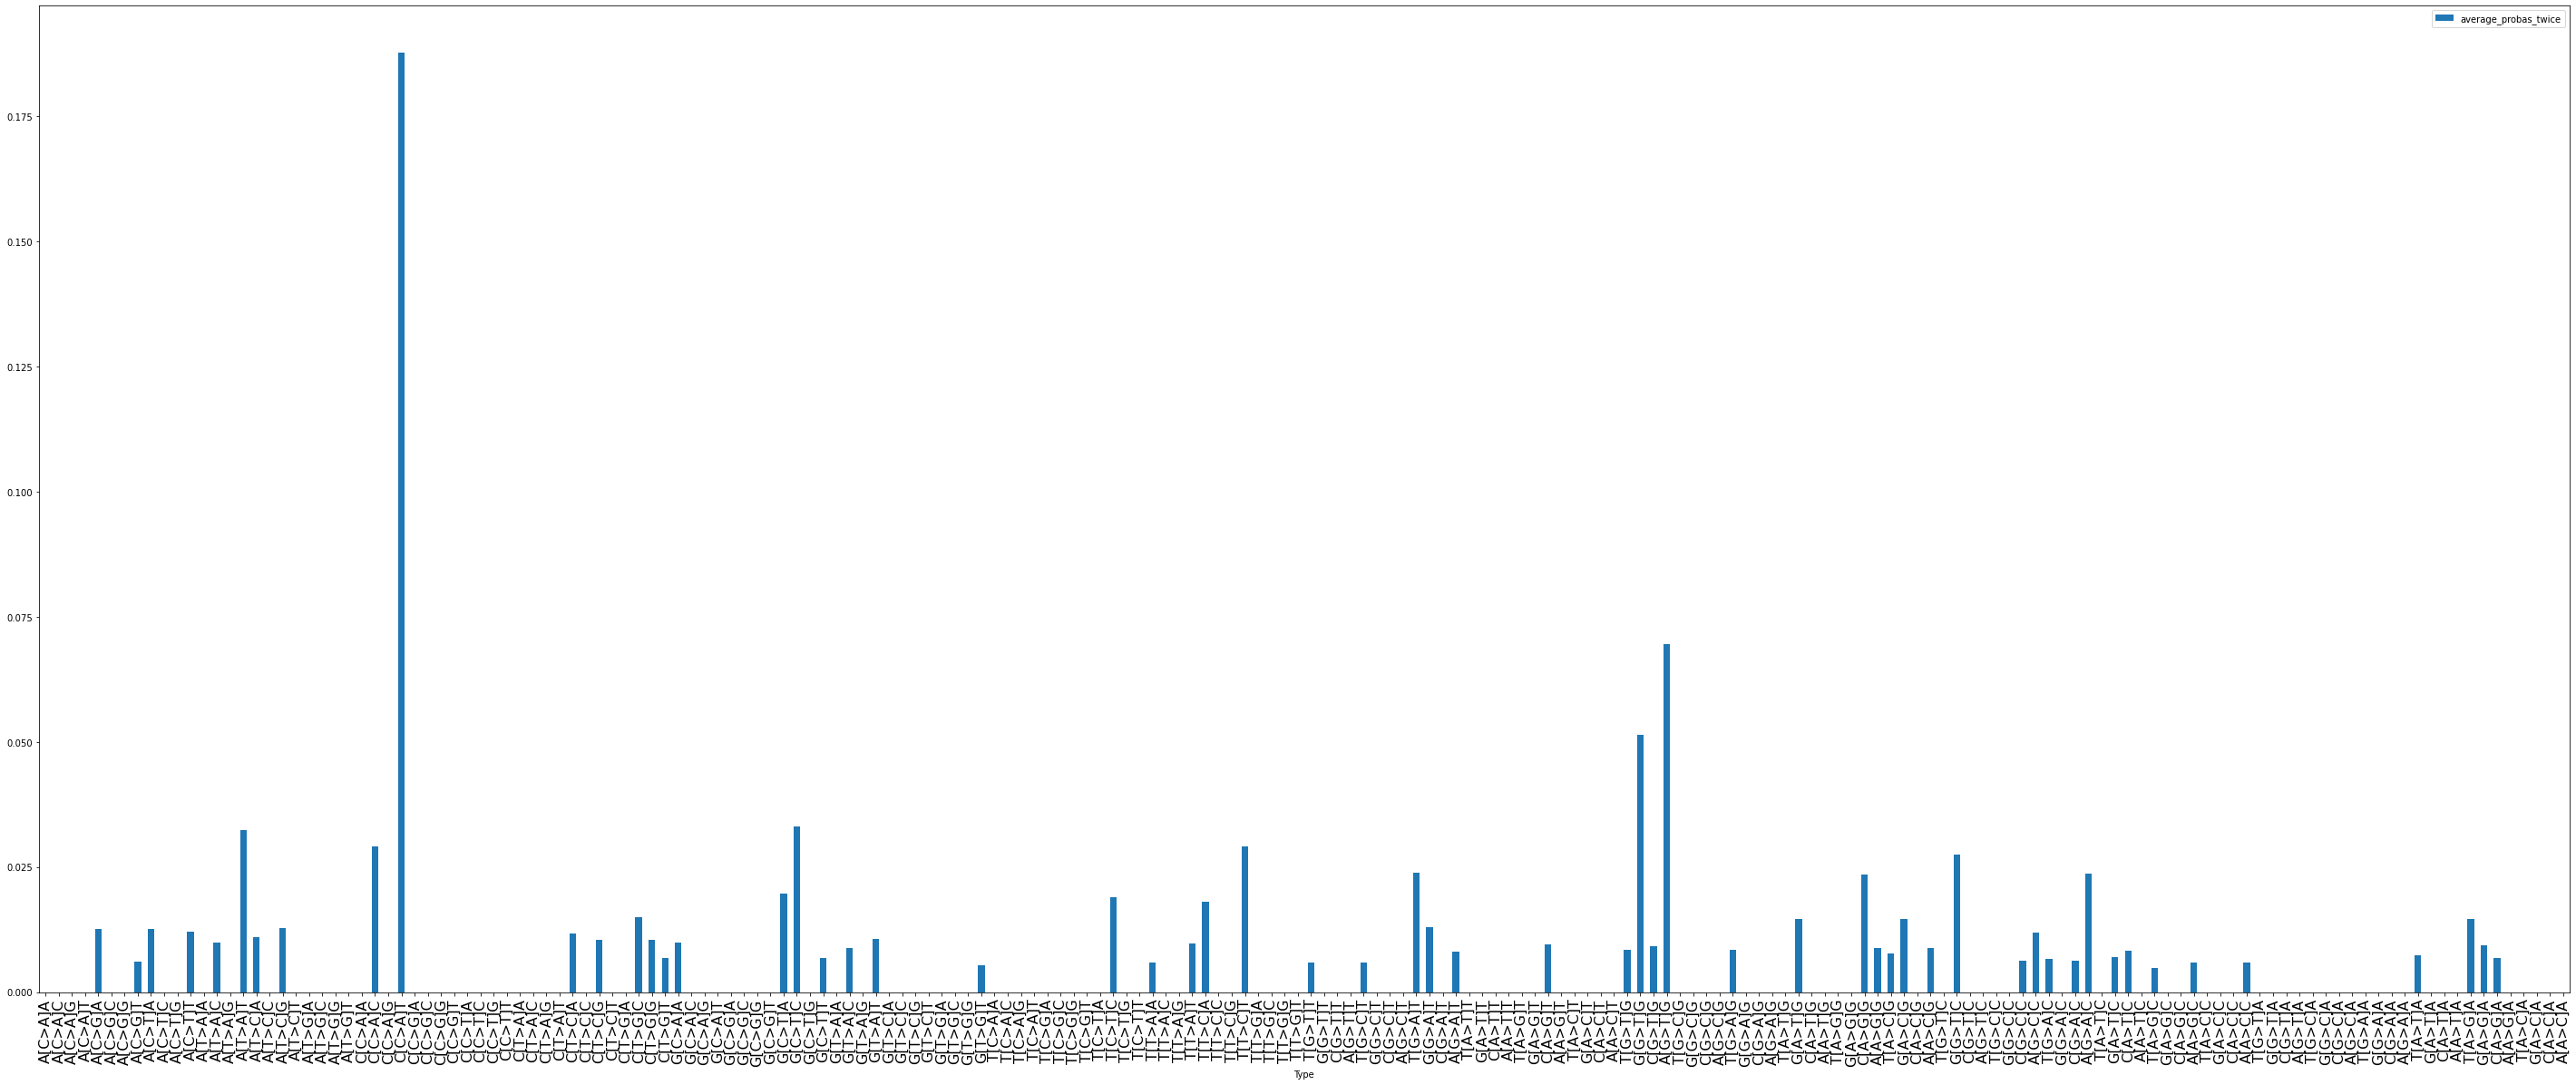

In [72]:
ax = twice_norm_mut_table.plot.bar(x='Type', y='average_probas_twice', rot=90, figsize=(50,20))
ax.tick_params(axis='x', which='both', labelsize=16)

Taking the normalised chosen sbs signature.

In [73]:
sbs.head(10)

,Type,SBS,Context
0,A[C>A]A,0.000563,ACA
1,A[C>A]C,0.001753,ACC
2,A[C>A]G,0.000118,ACG
3,A[C>A]T,0.001699,ACT
4,A[C>G]A,0.022409,ACA
5,A[C>G]C,0.005867,ACC
6,A[C>G]G,0.004403,ACG
7,A[C>G]T,0.010524,ACT
8,A[C>T]A,0.041637,ACA
9,A[C>T]C,0.013786,ACC


In [74]:
print(sbs['SBS'].values.sum()) #the signatures are not normalised, so we normalise them so the probabilities add up to 1

temp_sum = sbs['SBS'].values.sum()
sbs['SBS']= sbs['SBS'].values/temp_sum

print(sbs['SBS'].values.sum()) # now they are !

1.9113182402506281
0.9999999999999999


Now, we can do cosine similarity measures with the original signature and the once normalised resulting table.

In [75]:
u, v = sbs['SBS'], twice_norm_mut_table['probas_once']
d = cosine(u, v)
print("The cosine similarity measure is: ", 1-d)

The cosine similarity measure is:  0.7992149901681688


In [76]:
# Doing the same for the average one

u, v = sbs['SBS'], twice_norm_mut_table['average_probas_once']
d_av = cosine(u, v)
print("The cosine similarity measure is: ", 1-d_av)

The cosine similarity measure is:  0.7997410579773643


Now, we find the cosine similarity measure comparing the original signature with the twice normalised one:

In [77]:
signatures.head(300) # the original signatures

,Type,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,...,SBS85,SBS86,SBS87,SBS88,SBS89,SBS90,SBS91,SBS92,SBS93,SBS94
0,A[C>A]A,8.861572e-04,5.800168e-07,0.020808,0.042196,0.011998,0.000425,6.704351e-05,0.002329,0.004830,...,0.006080,0.002954,0.008973,0.000000,0.032169,0.002202,0.002945,0.011329,0.011573,0.015580
1,A[C>A]C,2.280405e-03,1.480043e-04,0.016507,0.033297,0.009438,0.000524,1.791162e-04,0.000461,0.001150,...,0.000880,0.003775,0.004573,0.000000,0.017694,0.000708,0.052997,0.009745,0.008096,0.024746
2,A[C>A]G,1.770314e-04,5.230151e-05,0.001751,0.015599,0.001850,0.000052,7.124623e-05,0.000186,0.000377,...,0.000306,0.000385,0.006209,0.000000,0.009671,0.000139,0.000204,0.004697,0.001761,0.001574
3,A[C>A]T,1.280227e-03,9.780282e-05,0.012205,0.029498,0.006609,0.000180,2.481610e-04,0.000710,0.001960,...,0.002717,0.003624,0.004957,0.001731,0.020744,0.001755,0.000131,0.007758,0.008421,0.011076
4,A[C>G]A,1.860330e-03,2.230064e-16,0.019708,0.006889,0.010098,0.000471,6.494214e-05,0.000009,0.001120,...,0.007235,0.052516,0.007866,0.000000,0.014817,0.000508,0.000243,0.003056,0.008857,0.007004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,T[T>C]T,4.330768e-03,3.580103e-05,0.013906,0.000636,0.018496,0.001741,8.125273e-04,0.002969,0.088107,...,0.094054,0.003439,0.006588,0.096365,0.006790,0.004000,0.001274,0.014287,0.014080,0.016766
92,T[T>G]A,2.230396e-16,1.670048e-05,0.007253,0.000377,0.005219,0.000105,1.280831e-04,0.000955,0.019302,...,0.007106,0.007136,0.008204,0.030583,0.006866,0.018583,0.005955,0.002208,0.053674,0.004072
93,T[T>G]C,5.510978e-05,7.040203e-05,0.006283,0.000174,0.006559,0.000287,1.160753e-04,0.001550,0.017401,...,0.006404,0.002369,0.002497,0.020773,0.002929,0.000185,0.000143,0.000301,0.013276,0.001235
94,T[T>G]G,5.831035e-04,9.540276e-05,0.008053,0.002320,0.006939,0.000324,2.231448e-16,0.001350,0.007641,...,0.003410,0.002011,0.001996,0.000000,0.005037,0.000293,0.000628,0.001743,0.012705,0.003048


In [78]:
# Used later to compare the types to feed to SigProExtractor

# For the random signature 
signatures['SBS_random'] = signatures_normed['SBS_random']

sbs_first_sig = signatures.loc[:,["Type", SBS]]

In [79]:
# First we get the original signatures and perform the manipulation on them as for the normalised ones
# we reverse complement to get 192 contexts
signatures_copy = signatures.copy()
signatures_copy["Type"] = signatures_copy["Type"].apply(replace_nucleotides) 
signatures_copy["Type"] = signatures_copy["Type"].apply(shift_nucleotides)
signatures = pd.concat([signatures, signatures_copy], ignore_index=True)

sbs_unnormed = signatures.loc[:,["Type", SBS]]
sbs_unnormed = sbs_unnormed.rename(columns={SBS: "SBS"})


sbs_unnormed.head(100)

,Type,SBS
0,A[C>A]A,0.000619
1,A[C>A]C,0.001391
2,A[C>A]G,0.000022
3,A[C>A]T,0.001241
4,A[C>G]A,0.008774
...,...,...
95,T[T>G]T,0.001511
96,T[G>T]T,0.000619
97,G[G>T]T,0.001391
98,C[G>T]T,0.000022


In [80]:
print(sbs_unnormed['SBS'].values.sum()) # they are not normalised to 1 but 2 

temp_sum = sbs_unnormed['SBS'].values.sum()
sbs_unnormed['SBS']= sbs_unnormed['SBS'].values/temp_sum

print(sbs_unnormed['SBS'].values.sum()) # now they are !

1.999999999999995
1.0


In [81]:
# Then we do the actual cosine similarity

u, v = sbs_unnormed['SBS'], twice_norm_mut_table['probas_twice']
d2 = cosine(u, v)
print("The cosine similarity measure is: ", 1-d2) 

The cosine similarity measure is:  0.8642223494757454


In [82]:
# and on the average ones

u, v = sbs_unnormed['SBS'], twice_norm_mut_table['average_probas_twice']
d2_av = cosine(u, v)
print("The cosine similarity measure is: ", 1-d2_av)

The cosine similarity measure is:  0.8639836711064142


In [83]:
# We save these cosine similarities in a table

data = {'Condition':['once normed', 'av once normed', 'twice normed', 'av twice normed'],
        'Cosine similarity':[1-d, 1-d_av, 1-d2, 1-d2_av]}
  
cosine_sim = pd.DataFrame(data)

filepath = Path('../results/results/{}_mut/cosine_sim_{}.tsv'.format(n_mut, n_mut))  
filepath.parent.mkdir(parents=True, exist_ok=True)  
cosine_sim.to_csv(filepath, sep="\t", index=False) 

In [84]:
cosine_sim.head()

,Condition,Cosine similarity
0,once normed,0.799215
1,av once normed,0.799741
2,twice normed,0.864222
3,av twice normed,0.863984


We can see that using the average of the original and mutated SARS-cov2 sequence trinucleotide content results in (modest) improvement, rather than using only the original trinucleotide content.

### Part 7: Feeding the mutational table to SigProExtractor 

We will now try to feed the mutational table unnormalised to the software SigProExtractor in order to see if it finds the right signature.

We should first transform the 192 input table into a 96 input and save it in the directory.

In [85]:
mut_table.head()

,Type,Number,Context
0,A[C>A]A,0,ACA
1,A[C>A]C,0,ACC
2,A[C>A]G,0,ACG
3,A[C>A]T,0,ACT
4,A[C>G]A,2,ACA


In [86]:
# split the table in two

mut_table_compl = mut_table[96:]
mut_table_sigpro = mut_table[:96]

In [87]:
print(mut_table_compl)

        Type  Number Context
96   T[G>T]T       1     TGT
97   G[G>T]T       0     GGT
98   C[G>T]T       0     CGT
99   A[G>T]T       0     AGT
100  T[G>C]T       1     TGT
..       ...     ...     ...
187  A[A>G]A       0     AAA
188  T[A>C]A       0     TAA
189  G[A>C]A       0     GAA
190  C[A>C]A       0     CAA
191  A[A>C]A       0     AAA

[96 rows x 3 columns]


In [88]:
print(mut_table_sigpro)

       Type  Number Context
0   A[C>A]A       0     ACA
1   A[C>A]C       0     ACC
2   A[C>A]G       0     ACG
3   A[C>A]T       0     ACT
4   A[C>G]A       2     ACA
..      ...     ...     ...
91  T[T>C]T       3     TTT
92  T[T>G]A       0     TTA
93  T[T>G]C       0     TTC
94  T[T>G]G       0     TTG
95  T[T>G]T       0     TTT

[96 rows x 3 columns]


In [89]:
# Now we add the numbers of the mut_table_compl to mut_table_sigpro

sum_column = mut_table_sigpro['Number'].values + mut_table_compl['Number'].values
mut_table_96 = mut_table_sigpro.copy()

mut_table_96["Number"] = sum_column
mut_table_96.head()

,Type,Number,Context
0,A[C>A]A,1,ACA
1,A[C>A]C,0,ACC
2,A[C>A]G,0,ACG
3,A[C>A]T,0,ACT
4,A[C>G]A,3,ACA


It seems to work ! Now we remove the context and check if the types are the same as for the sbs cosmic signature.

In [90]:
mut_table_96.drop('Context', inplace=True, axis=1)
mut_table_96.head(100)

,Type,Number
0,A[C>A]A,1
1,A[C>A]C,0
2,A[C>A]G,0
3,A[C>A]T,0
4,A[C>G]A,3
...,...,...
91,T[T>C]T,3
92,T[T>G]A,0
93,T[T>G]C,0
94,T[T>G]G,0


In [91]:
sbs.head(100)

,Type,SBS,Context
0,A[C>A]A,0.000294,ACA
1,A[C>A]C,0.000917,ACC
2,A[C>A]G,0.000062,ACG
3,A[C>A]T,0.000889,ACT
4,A[C>G]A,0.011724,ACA
...,...,...,...
95,T[T>G]T,0.000496,TTT
96,T[G>T]T,0.000294,TGT
97,G[G>T]T,0.000917,GGT
98,C[G>T]T,0.000062,CGT


In [92]:
mut_table_96['Type'].equals(sbs_first_sig['Type'])

True

They are indeed equal ! We can now save the mutational table with 96 input and try SigProExtractor on it. 

In [93]:
filepath = Path('../results/results/{}_mut/mut_table_96_{}.tsv'.format(n_mut, n_mut))  
filepath.parent.mkdir(parents=True, exist_ok=True)  
mut_table_96.to_csv(filepath, sep="\t", index=False) 

### To feed it to SigProExtractor

you need to open a terminal in the corresponding mutational_signatures directory, and, after having installed the software and the reference genome in a conda environment for instance (for me: workon mutagen2), do the following commands:

$python3 -> to lauch an interactive python console

$from SigProfilerExtractor import sigpro as sig

$sig.sigProfilerExtractor("matrix", "results/results_SigProExtractor/n_mut", "results/results/n_mut/mut_table_96(_norm)_n.tsv", reference_genome="GRCh37", minimum_signatures=1, maximum_signatures=3, nmf_replicates=100)

Here we are only looking for one signature, so we put the max signatures to be found to 3, arbirtrarily. This can be optimised. n is the variable representing the number of mutations desired.

Now we have to see if it is better to find the right signature with the normalised mutational table. We take the averaged probabilities since the cosine similarity is improved using this.

In [94]:
mut_table_96_norm = twice_norm_mut_table.loc[:,["Type", "average_probas_twice"]]
mut_table_96_norm  = mut_table_96_norm.rename(columns={"average_probas_twice": "Number"})
mut_table_96_norm.head()

,Type,Number
0,A[C>A]A,0.000000
1,A[C>A]C,0.000000
2,A[C>A]G,0.000000
3,A[C>A]T,0.000000
4,A[C>G]A,0.012622


We do the same manipulations as above.

In [95]:
# split the table in two

mut_table_compl = mut_table_96_norm[96:]
mut_table_sigpro = mut_table_96_norm[:96]

sum_column = mut_table_sigpro['Number'].values + mut_table_compl['Number'].values
mut_table_96_norm = mut_table_sigpro.copy()

mut_table_96_norm["Number"] = sum_column
mut_table_96_norm.head()

,Type,Number
0,A[C>A]A,0.005958
1,A[C>A]C,0.000000
2,A[C>A]G,0.000000
3,A[C>A]T,0.000000
4,A[C>G]A,0.018580


We have to transform the probabilities into real numbers.

In [96]:
# Find the minimum value not = 0

temp = mut_table_96_norm.copy()
temp['Number'] = temp['Number'].replace(0,np.nan)
min_nb = temp[temp.Number == temp.Number.min(skipna = True)] 
print(min_nb)

       Type    Number
64  G[T>C]A  0.004723


In [97]:
# We multiply by this factor to get real numbers
mult_factor = 1/min_nb.Number.values
print(mult_factor)

[211.7119396]


In [98]:
mut_table_96_norm['Number'] *= mult_factor[0]
mut_table_96_norm.head()

,Type,Number
0,A[C>A]A,1.261412
1,A[C>A]C,0.000000
2,A[C>A]G,0.000000
3,A[C>A]T,0.000000
4,A[C>G]A,3.933686


In [99]:
# We round up to an integer, loosing a bit of information but not too much regarding the scale of the numbers

mut_table_96_norm = mut_table_96_norm.round(0)
mut_table_96_norm.Number = mut_table_96_norm.Number.astype(int)
mut_table_96_norm.head()

,Type,Number
0,A[C>A]A,1
1,A[C>A]C,0
2,A[C>A]G,0
3,A[C>A]T,0
4,A[C>G]A,4


In [100]:
# Save it in a tsv file
filepath = Path('../results/results/{}_mut/mut_table_96_norm_{}.tsv'.format(n_mut, n_mut))  
filepath.parent.mkdir(parents=True, exist_ok=True)  
mut_table_96_norm.to_csv(filepath, sep="\t", index=False) 

Now we can repeat the same procedure and feed it to SigProExtractor.

# Diverse tests and follow-ups

a) Small test for the cosine similarity measure:

In [101]:
A = np.array([2, 1, 2, 3, 2, 9])
B = np.array([2, 1, 2, 3, 2, 9])


print(cosine(A, B)) # this is the cosine distance
print(1-cosine(A, B)) # this is the real cosine similarity measure
print(np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))) #which gives the same as the formula given here

0
1
1.0


b) We can now see if the normalisation from human sbs to normalised sbs made important changes by measuring the cosine similarity.

In [102]:
u, v = sbs_unnormed['SBS'], sbs['SBS']
print(1-cosine(u,v))

0.9411182967547161


We can see that it did not really have an impact. Indeed, the human trinucleotide content is quite uniform as can be seen in the bar plot below.

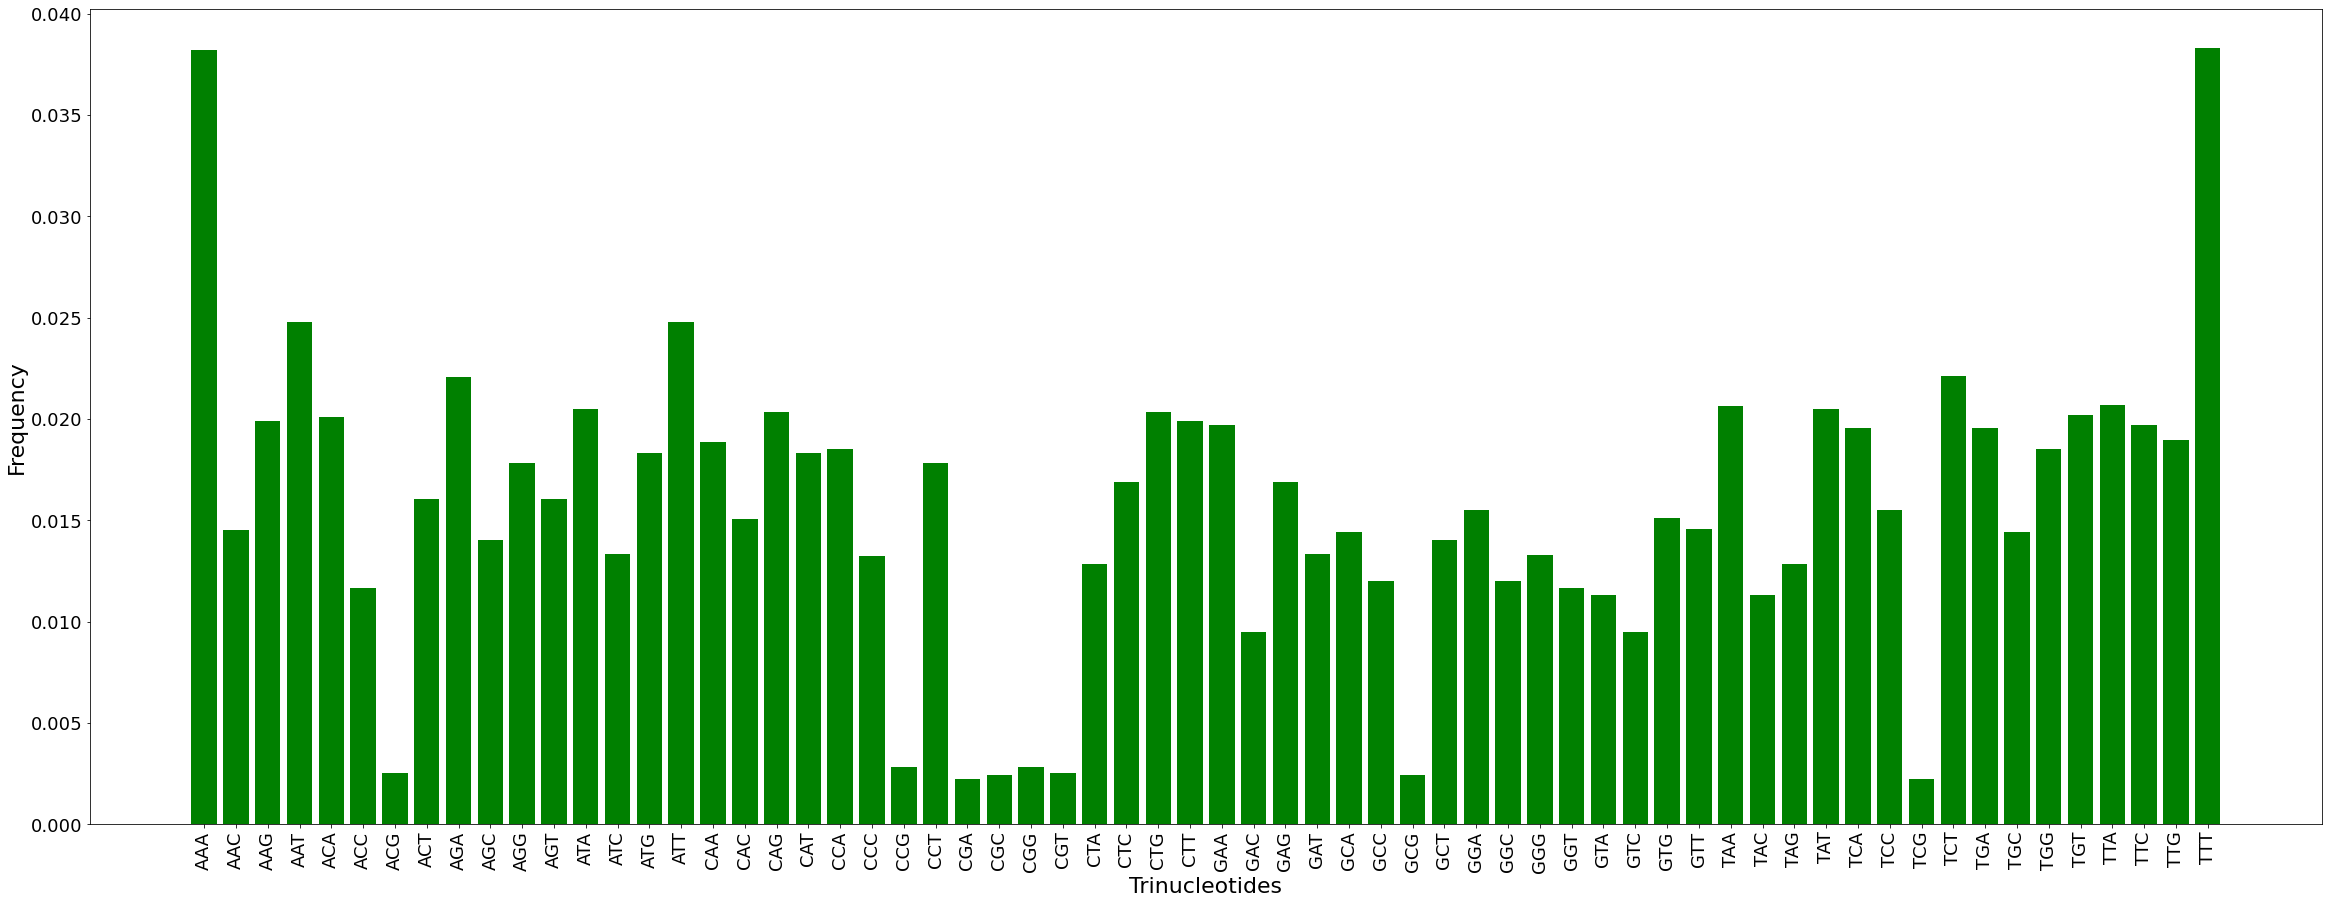

In [116]:
plt.bar(hum_triplets.keys(), hum_triplets.values(), color='g')
plt.rcParams["figure.figsize"] = (40,15)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18, rotation = 90)
plt.xlabel('Trinucleotides', fontsize=22)
plt.ylabel('Frequency', fontsize=22)
plt.show()

In [104]:
val = 1/64
uniform_sig = np.full((1, 64), val)

u, v = np.fromiter(hum_triplets.values(), dtype=float), uniform_sig
print("For human triplets:", 1-cosine(u,v))

For human triplets: 0.9104120021761561


c) Now we can see if the normalisation to the sars-cov2 trinucleotide content changes something:

In [105]:
u, v = twice_norm_mut_table['Number'], twice_norm_mut_table['once_normalised_number']
print(1-cosine(u,v))

0.8998313850809665


It changes more. Indeed the SARS-cov2 trinucleotide content is not as uniform, as seen in the following bar plot.

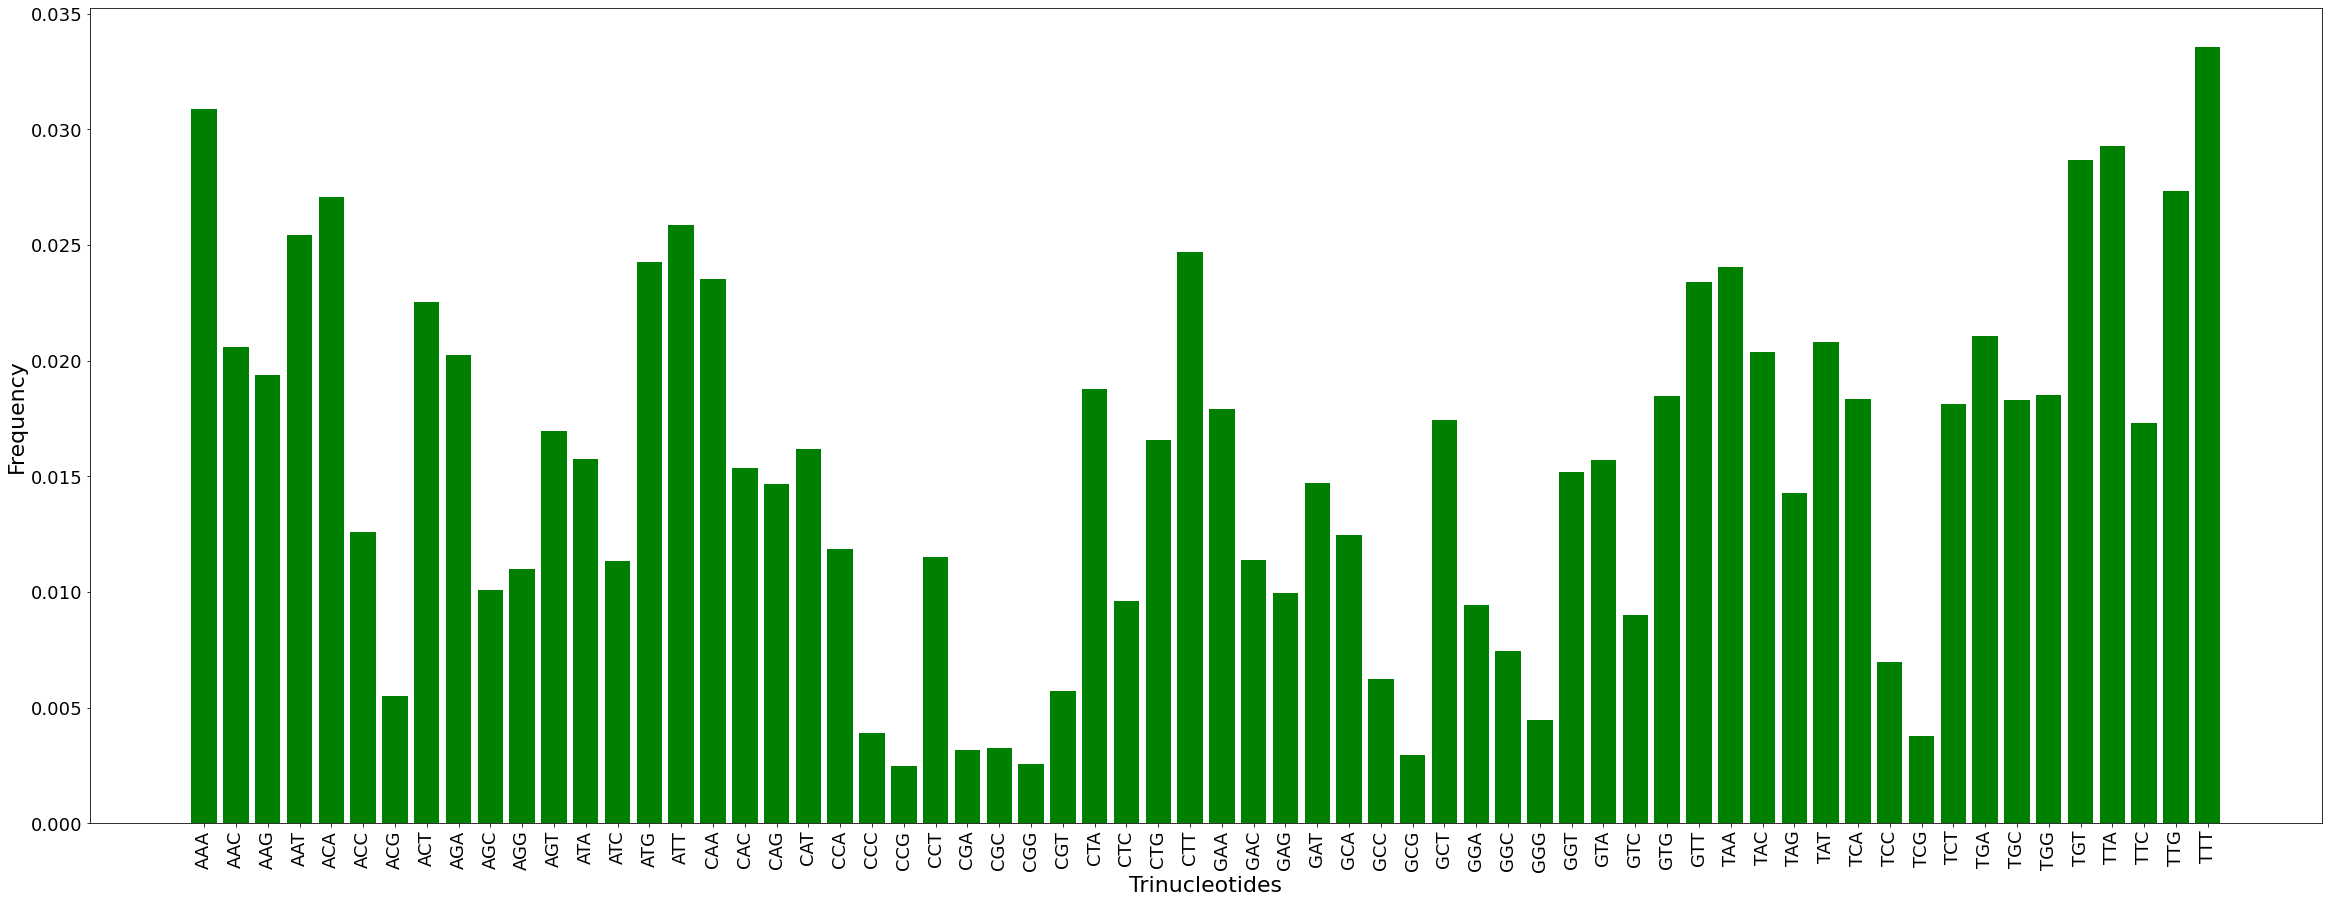

In [106]:
plt.bar(triplets.keys(), triplets.values(), color='g')
plt.rcParams["figure.figsize"] = (40,15)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18, rotation = 90)
plt.xlabel('Trinucleotides', fontsize=22)
plt.ylabel('Frequency', fontsize=22)
plt.show()

In [107]:
# to see how much it differs from the uniform spectrum 

u, v = np.fromiter(triplets.values(), dtype=float), uniform_sig
print("For covid triplets:", 1-cosine(u,v))

For covid triplets: 0.8941301016171275


In [117]:
# and see covid and human trinucleotide content

u, v = np.fromiter(triplets.values(), dtype=float), np.fromiter(hum_triplets.values(), dtype=float)
print("For human and covid triplets:", 1-cosine(u,v))

For human and covid triplets: 0.9610808570040508


Test to see how SBS20, 25 and 34 are different from the uniform signature.

It looks with the eye that SBS25 is more uniform and SBS34 more caracteristic.

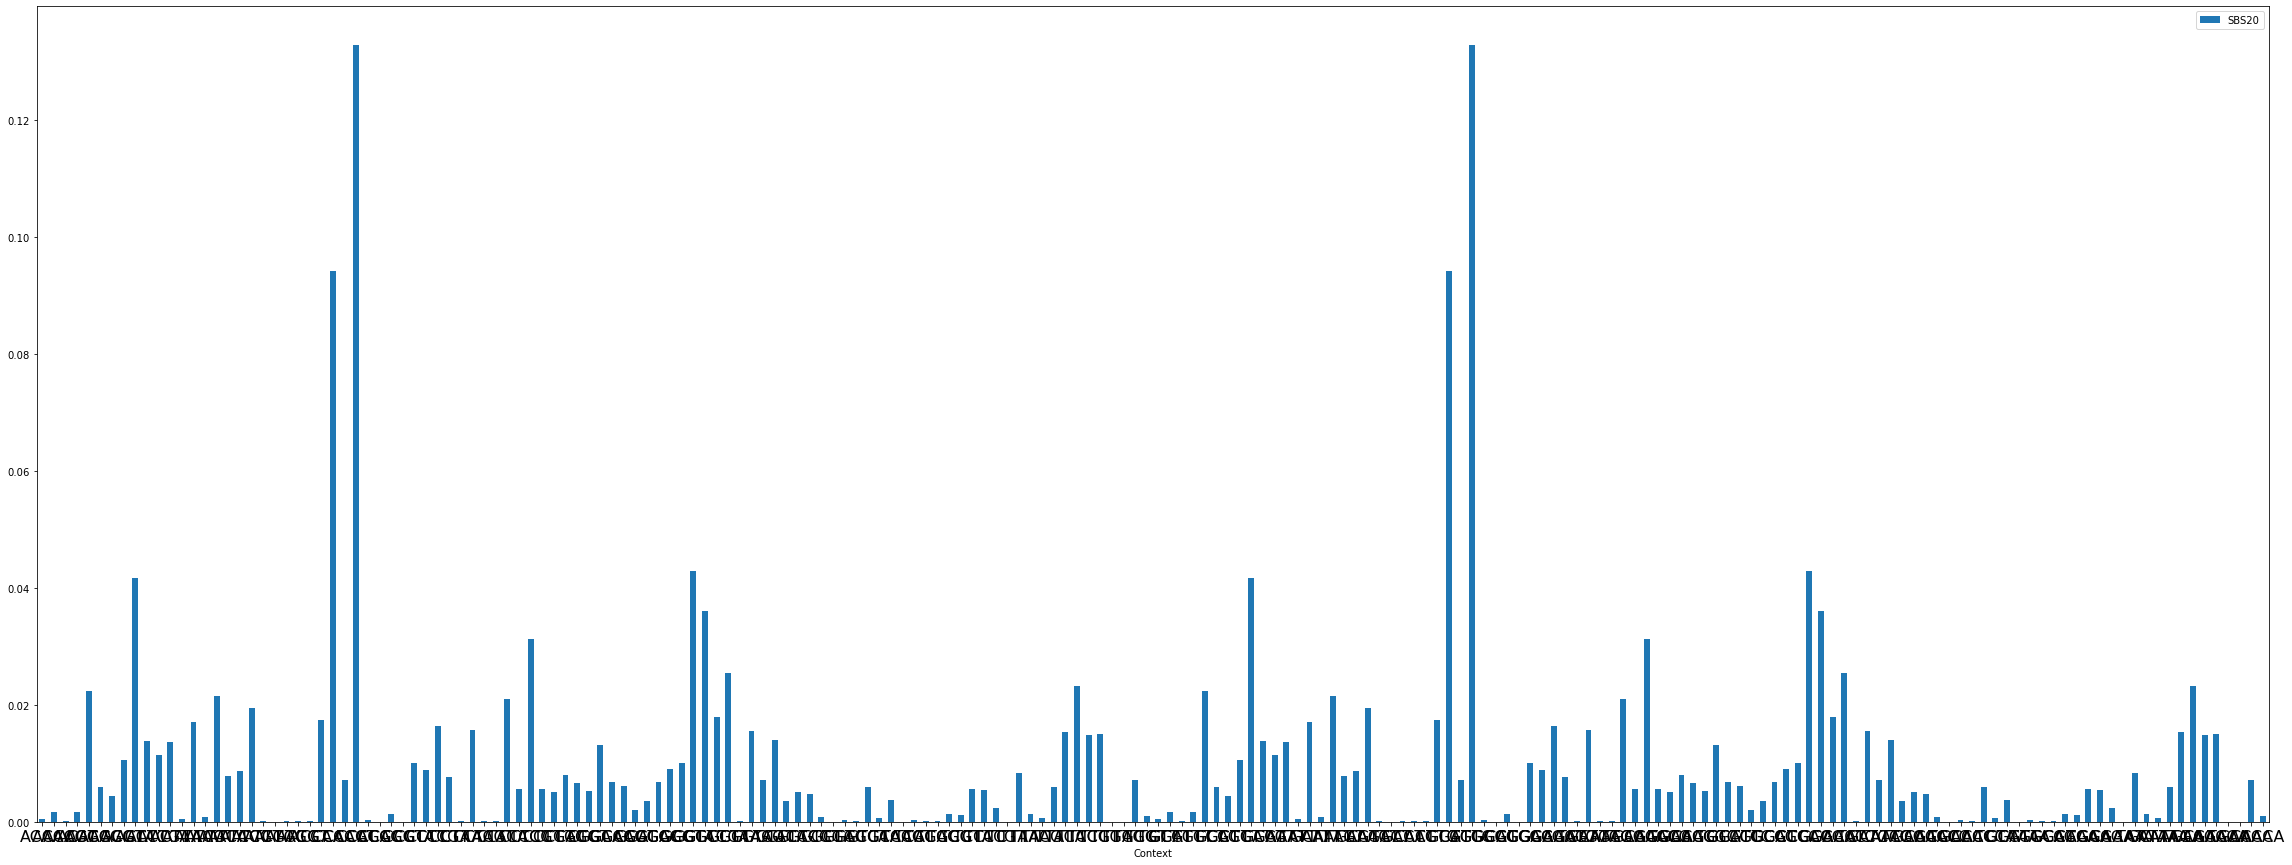

In [109]:
ax = signatures_normed.plot.bar(x='Context', y="SBS20", rot=0)
ax.tick_params(axis='x', which='both', labelsize=16)

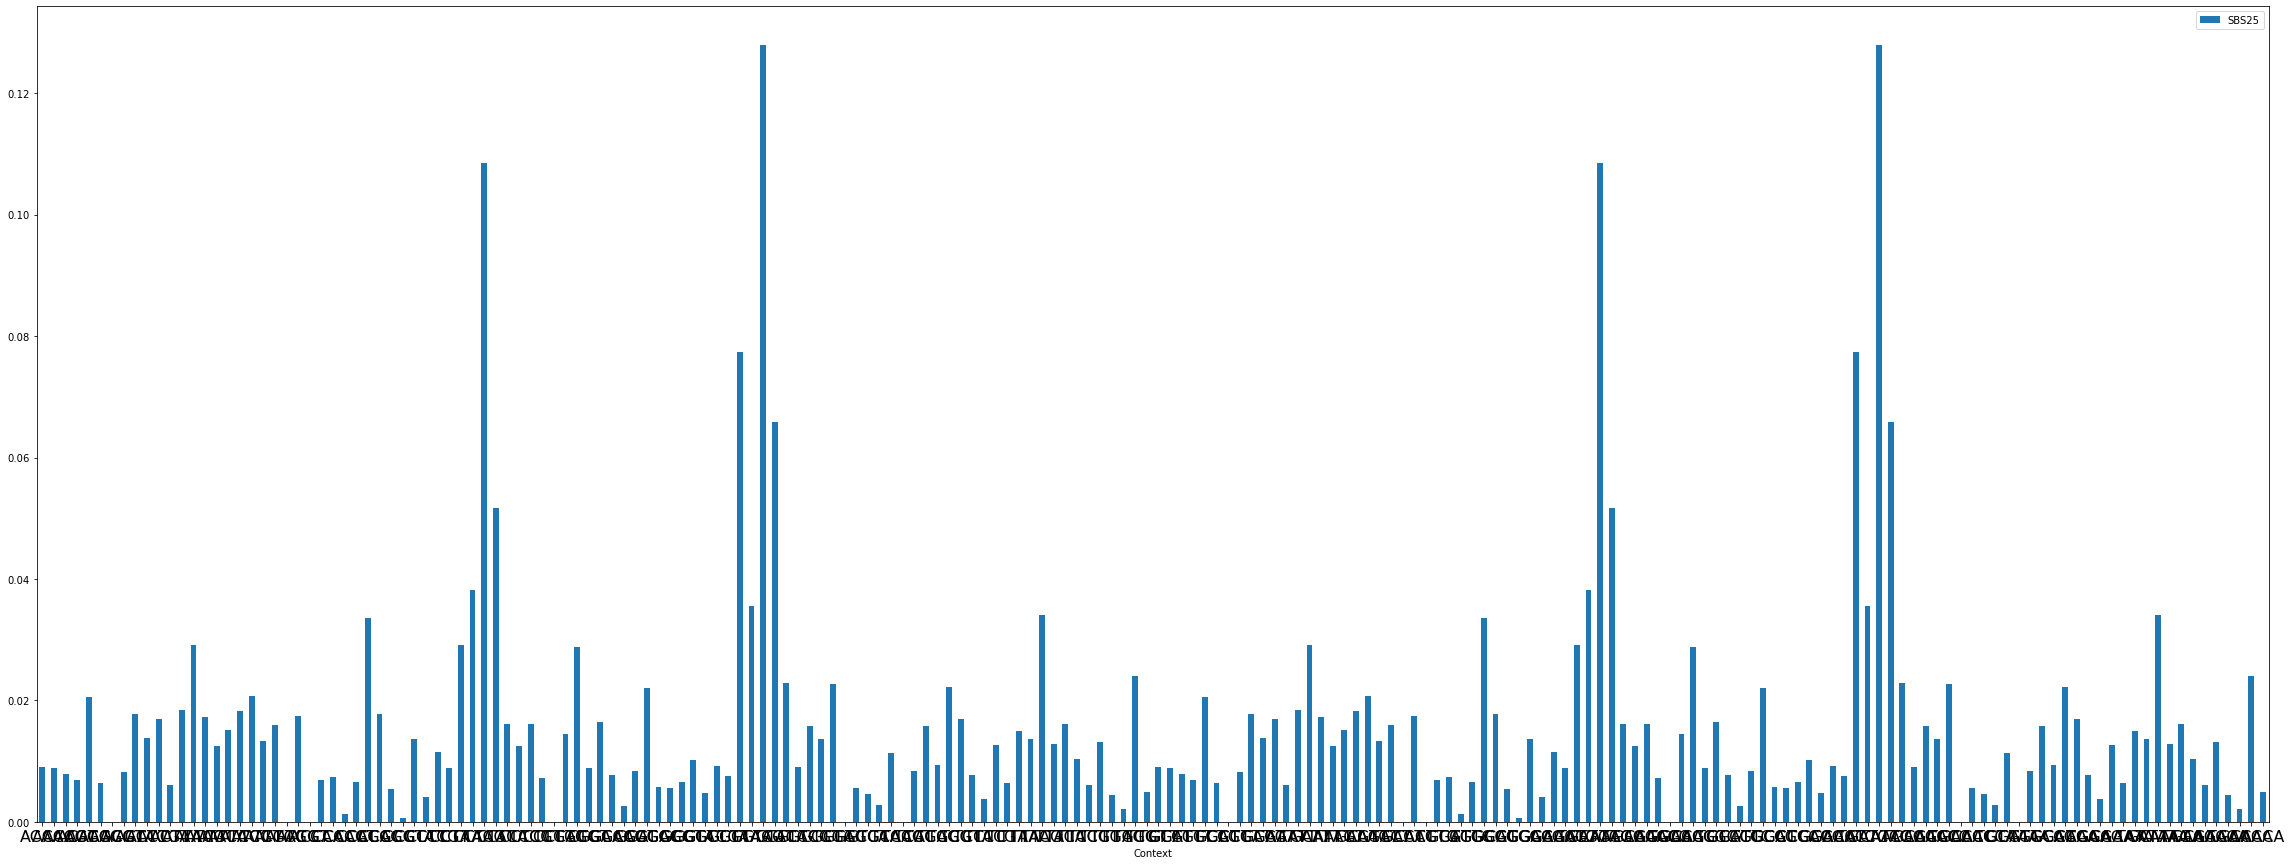

In [110]:
ax = signatures_normed.plot.bar(x='Context', y="SBS25", rot=0)
ax.tick_params(axis='x', which='both', labelsize=16)

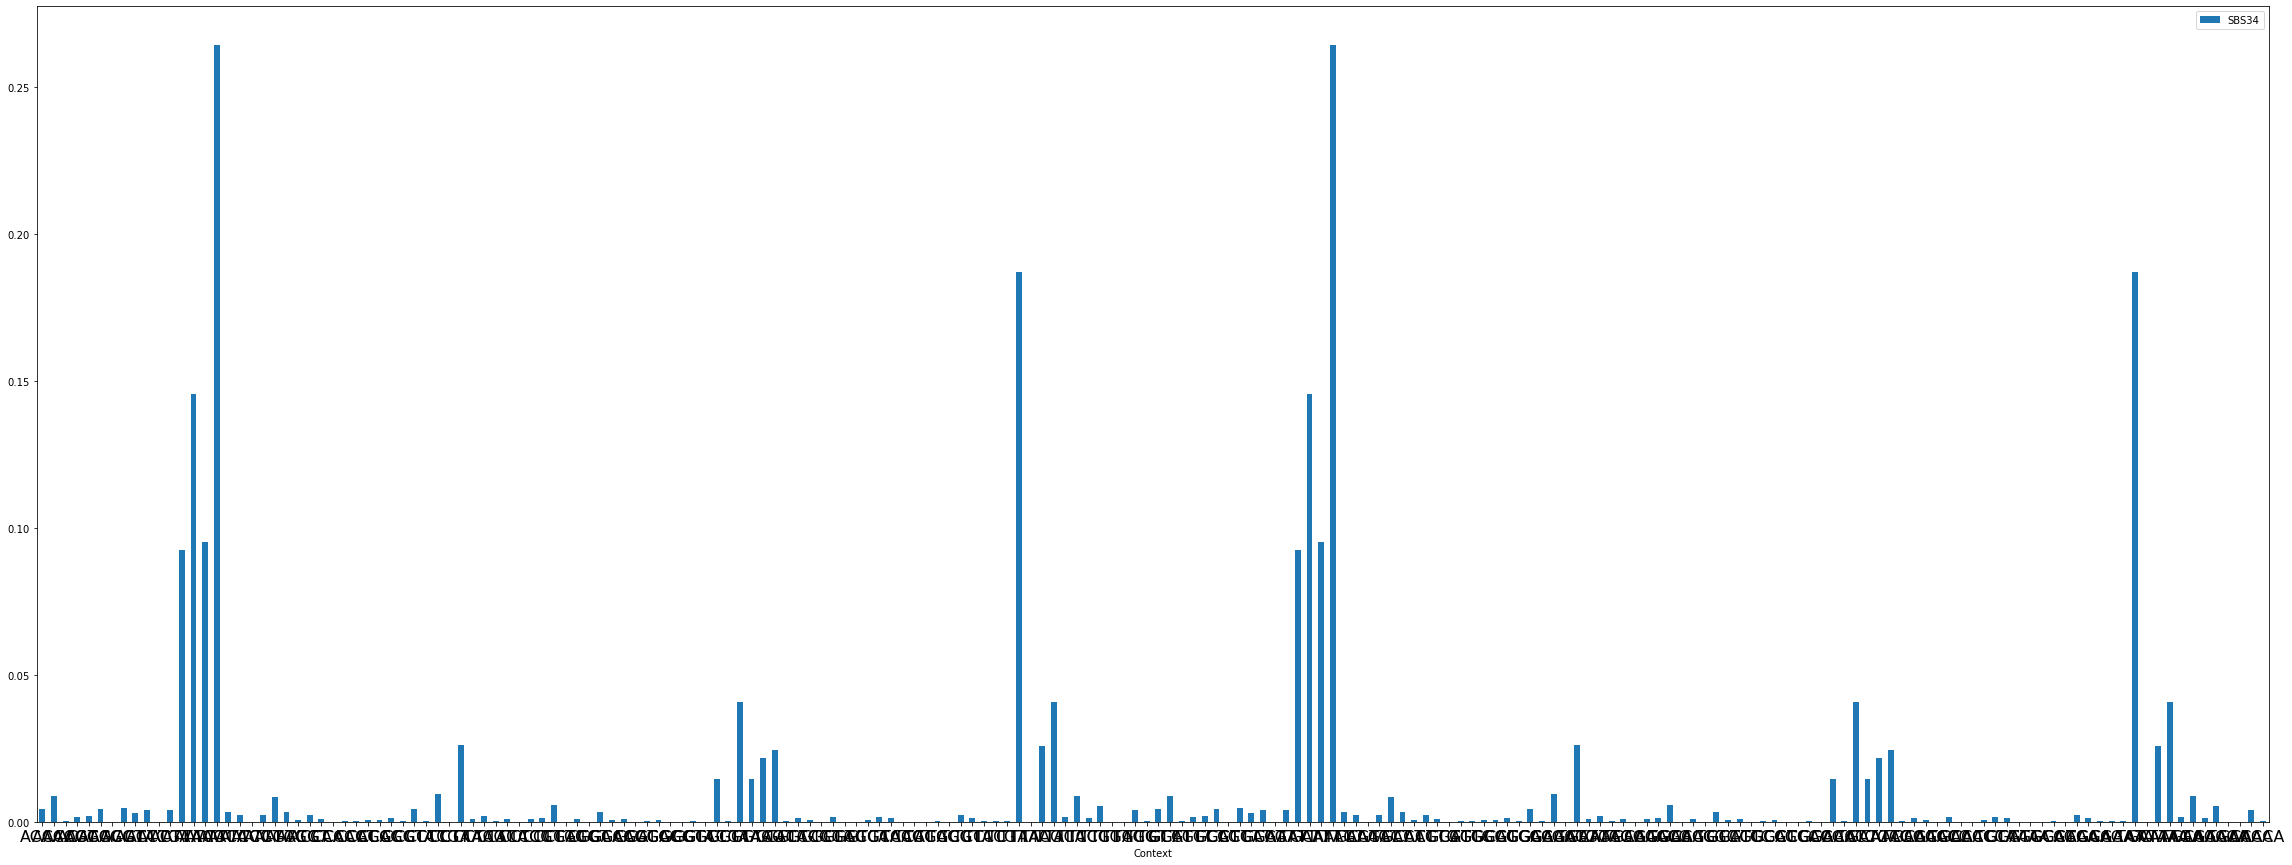

In [111]:
ax = signatures_normed.plot.bar(x='Context', y="SBS34", rot=0)
ax.tick_params(axis='x', which='both', labelsize=16)

Let's try to calculate the cosine similarity compared to a fully uniform mutational signature.

In [112]:
val = 1/192
uniform_sig = np.full((1, 192), val)

In [113]:
u, v = signatures_normed['SBS20'], uniform_sig
print("For SBS20:", 1-cosine(u,v))

For SBS20: 0.4871021698381861


In [114]:
u, v = signatures_normed['SBS25'], uniform_sig
print("For SBS25:", 1-cosine(u,v))

For SBS25: 0.6326817090195761


In [115]:
u, v = signatures_normed['SBS34'], uniform_sig
print("For SBS34:", 1-cosine(u,v))

For SBS34: 0.2960392912612684


So our intuition was correct: SBS25 looks the most like a uniform signature, SBS20 is intermediate and SBS34 looks most atypical.

However, for SigProExtractor, it is more easy to detect SBS25 as 100% responsible for the signature, then SBS34 and only then SBS20.

Thus, it doesn't seem to be the case that a more uniform signature is harder to find. Or maybe, the atypicity of a mutational signature cannot be easily seen by eye/with the cosine similarity metric. 